# Lab 10 - Projekt podsumowujący zajęcia dotyczące testowania hipotez

Autor: Michał Waszkowiak

## Wczytanie bibliotek i danych

### Biblioteki

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor


### Dane

In [3]:
data = pd.read_csv('27521-0001-Data.tsv', sep='\t')

Wybranie tylko tych wierszy, gdzie wartość w kolumnie `DEPRESSIONINDEX` jest w przedziale od 0 do 9

In [4]:
depression_data = data[(data['DEPRESSIONINDEX'] >= 0) & (data['DEPRESSIONINDEX'] <= 9)]

Wyselekcjonowanie cech, które będą poddane wstępnej analizie

In [5]:
selected_columns = [
    # Wskaźnik depresji
    'DEPRESSIONINDEX',

    # Wskaźniki grup wiekowych, płci i rasy
    'CATAG2', 'IRSEX', 'NEWRACE2',

    # Wskaźniki uzależnień
    'ANYINDEX', 'MJANDCOKE', 'ILLICITDRUGUSE', 'LSYRILLICIT', 'COKECRACK', 
    'OTHERILLICIT', 'MARJLTYR', 'MJCOKELY', 'COCCRKLY', 'MJGT12MO', 
    'COCGT12MO', 'ANYGT12MO', 'ALCFMFPB',

    # Wskaźniki edukacji
    'IREDUC2', 'EDU_DUMMY',

    # Wskaźniki ekonomiczne
    'INCOME', 'INCOME_R', 'POVERTY', 'IRPRVHLT', 'WORKFORCE', 'EMPSTAT4',

    # Wskaźniki warunków zamieszkania
    'REVERSEPOP', 'MOVESPY2', 'CACHAR', 'CATYPE',

    # Wskaźniki konfliktów z prawem
    'CRIMEHIST', 'ANYSDRUG', 'ANYATTACK', 'ANYTHEFT', 'NUMARREST',

    # Stan zdrowia
    'HEALTH2', 'SCHDSICK', 'SCHDSKIP', 'TXLCAD', 'DSTCHEER', 'DSTNRVOS',

    # Problemy ze zmęczeniem
    'ADWRENRG', 'YOWRENRG', 'AD_MDEA6', 'YO_MDEA6',

    # Zaburzenia apetytu
    'AD_MDEA3', 'YO_MDEA3', 'ADWRELES', 'YOWRELES',

    # Problemy ze snem
    'AD_MDEA4', 'YO_MDEA4', 'ADWRSLEP', 'YOWRSLEP', 'ADWRSMOR', 'YOWRSMOR',

    # Myśli samobójcze
    'ADWRSATP', 'YOWRSATP', 'ADWRSPLN', 'YOWRSPLN', 'ADWRDLOT',
    'YOWRDLOT', 'ADWRSTHK', 'YOWRSTHK',

    # Informacje rodzinne
    'IRMARIT', 'NOMARR2', 'RKIDSHH', 'MARRIED', 'CHILDRENINHOME'
]

In [6]:
filtered_data = depression_data[selected_columns]
print(filtered_data.shape[0])

36972


Uzupełnienie `missing values` w taki sposób, żeby dalsza analiza była łatwiejsza

In [7]:
filtered_data.loc[filtered_data['ANYINDEX'] == -1.0000, 'ANYINDEX'] = 0.1429

filtered_data.loc[filtered_data['COKECRACK'] == -1, 'COKECRACK'] = 1

filtered_data.loc[filtered_data['MJGT12MO'] == -9, 'MJGT12MO'] = 1

filtered_data.loc[filtered_data['COCGT12MO'] == -9, 'COCGT12MO'] = 1

filtered_data.loc[filtered_data['ANYGT12MO'] == -9, 'ANYGT12MO'] = 1

filtered_data.loc[filtered_data['ALCFMFPB'] == 83, 'ALCFMFPB'] = 2
filtered_data.loc[filtered_data['ALCFMFPB'] == 91, 'ALCFMFPB'] = 2
filtered_data.loc[filtered_data['ALCFMFPB'] == 93, 'ALCFMFPB'] = 2
filtered_data.loc[filtered_data['ALCFMFPB'] == 94, 'ALCFMFPB'] = 1
filtered_data.loc[filtered_data['ALCFMFPB'] == 97, 'ALCFMFPB'] = 1
filtered_data.loc[filtered_data['ALCFMFPB'] == 98, 'ALCFMFPB'] = 1

filtered_data.loc[filtered_data['WORKFORCE'] == -1, 'WORKFORCE'] = 0

filtered_data.loc[filtered_data['MOVESPY2'] == 994, 'MOVESPY2'] = 2
filtered_data.loc[filtered_data['MOVESPY2'] == 997, 'MOVESPY2'] = 1
filtered_data.loc[filtered_data['MOVESPY2'] == 998, 'MOVESPY2'] = 3

filtered_data.loc[filtered_data['CACHAR'] == -9, 'CACHAR'] = 3

filtered_data.loc[filtered_data['CATYPE'] == -9, 'CATYPE'] = 1

filtered_data.loc[filtered_data['CRIMEHIST'] == -1, 'CRIMEHIST'] = 1

filtered_data.loc[filtered_data['ANYSDRUG'] == -1, 'ANYSDRUG'] = 1

filtered_data.loc[filtered_data['ANYATTACK'] == -1, 'ANYATTACK'] = 1

filtered_data.loc[filtered_data['ANYTHEFT'] == -1, 'ANYTHEFT'] = 1

np.random.seed(0)
missing_values = filtered_data[filtered_data['NUMARREST'] == -9].index
new_values = np.random.choice([1, 2, 3], size=len(missing_values))
filtered_data.loc[missing_values, 'NUMARREST'] = new_values

filtered_data.loc[filtered_data['HEALTH2'] == -9, 'HEALTH2'] = 4

filtered_data.loc[filtered_data['SCHDSICK'] == 89, 'SCHDSICK'] = 90
filtered_data.loc[filtered_data['SCHDSICK'] == 94, 'SCHDSICK'] = 90
filtered_data.loc[filtered_data['SCHDSICK'] == 97, 'SCHDSICK'] = 90
filtered_data.loc[filtered_data['SCHDSICK'] == 98, 'SCHDSICK'] = 90

filtered_data.loc[filtered_data['SCHDSKIP'] == 89, 'SCHDSKIP'] = 90
filtered_data.loc[filtered_data['SCHDSKIP'] == 94, 'SCHDSKIP'] = 90
filtered_data.loc[filtered_data['SCHDSKIP'] == 97, 'SCHDSKIP'] = 90
filtered_data.loc[filtered_data['SCHDSKIP'] == 98, 'SCHDSKIP'] = 90

filtered_data.loc[filtered_data['DSTCHEER'] == 85, 'DSTCHEER'] = 99
filtered_data.loc[filtered_data['DSTCHEER'] == 94, 'DSTCHEER'] = 3
filtered_data.loc[filtered_data['DSTCHEER'] == 97, 'DSTCHEER'] = 1
filtered_data.loc[filtered_data['DSTCHEER'] == 98, 'DSTCHEER'] = 2

filtered_data.loc[filtered_data['DSTNRVOS'] == 85, 'DSTNRVOS'] = 99
filtered_data.loc[filtered_data['DSTNRVOS'] == 89, 'DSTNRVOS'] = 99
filtered_data.loc[filtered_data['DSTNRVOS'] == 94, 'DSTNRVOS'] = 2
filtered_data.loc[filtered_data['DSTNRVOS'] == 97, 'DSTNRVOS'] = 1
filtered_data.loc[filtered_data['DSTNRVOS'] == 98, 'DSTNRVOS'] = 2

filtered_data.loc[filtered_data['YO_MDEA6'] == 94, 'YO_MDEA6'] = 2
filtered_data.loc[filtered_data['YO_MDEA6'] == 97, 'YO_MDEA6'] = 1

filtered_data.loc[filtered_data['AD_MDEA6'] == 94, 'AD_MDEA6'] = 2
filtered_data.loc[filtered_data['AD_MDEA6'] == 97, 'AD_MDEA6'] = 1

mdea6_yo_1 = filtered_data[filtered_data['YO_MDEA6'] == 1].index
mdea6_yo_2 = filtered_data[filtered_data['YO_MDEA6'] == 2].index
mdea6_ad_1 = filtered_data[filtered_data['AD_MDEA6'] == 1].index
mdea6_ad_2 = filtered_data[filtered_data['AD_MDEA6'] == 2].index
filtered_data['MDEA6'] = None 
filtered_data.loc[mdea6_yo_1, 'MDEA6'] = 1
filtered_data.loc[mdea6_yo_2, 'MDEA6'] = 2
filtered_data.loc[mdea6_ad_1, 'MDEA6'] = 1
filtered_data.loc[mdea6_ad_2, 'MDEA6'] = 2
filtered_data['MDEA6'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['YOWRENRG'] == 94, 'YOWRENRG'] = 2
filtered_data.loc[filtered_data['YOWRENRG'] == 97, 'YOWRENRG'] = 1
filtered_data.loc[filtered_data['YOWRENRG'] == 98, 'YOWRENRG'] = 1

filtered_data.loc[filtered_data['ADWRENRG'] == 94, 'ADWRENRG'] = 2
filtered_data.loc[filtered_data['ADWRENRG'] == 97, 'ADWRENRG'] = 1
filtered_data.loc[filtered_data['ADWRENRG'] == 98, 'ADWRENRG'] = 1

wrenrg_yo_1 = filtered_data[filtered_data['YOWRENRG'] == 1].index
wrenrg_yo_2 = filtered_data[filtered_data['YOWRENRG'] == 2].index
wrenrg_ad_1 = filtered_data[filtered_data['ADWRENRG'] == 1].index
wrenrg_ad_2 = filtered_data[filtered_data['ADWRENRG'] == 2].index
filtered_data['WRENRG'] = None 
filtered_data.loc[wrenrg_yo_1, 'WRENRG'] = 1
filtered_data.loc[wrenrg_yo_2, 'WRENRG'] = 2
filtered_data.loc[wrenrg_ad_1, 'WRENRG'] = 1
filtered_data.loc[wrenrg_ad_2, 'WRENRG'] = 2
filtered_data['WRENRG'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['YO_MDEA3'] == 94, 'YO_MDEA3'] = 2
filtered_data.loc[filtered_data['YO_MDEA3'] == 97, 'YO_MDEA3'] = 1

filtered_data.loc[filtered_data['AD_MDEA3'] == 94, 'AD_MDEA3'] = 2
filtered_data.loc[filtered_data['AD_MDEA3'] == 97, 'AD_MDEA3'] = 1

mdea3_yo_1 = filtered_data[filtered_data['YO_MDEA3'] == 1].index
mdea3_yo_2 = filtered_data[filtered_data['YO_MDEA3'] == 2].index
mdea3_ad_1 = filtered_data[filtered_data['AD_MDEA3'] == 1].index
mdea3_ad_2 = filtered_data[filtered_data['AD_MDEA3'] == 2].index
filtered_data['MDEA3'] = None 
filtered_data.loc[mdea3_yo_1, 'MDEA3'] = 1
filtered_data.loc[mdea3_yo_2, 'MDEA3'] = 2
filtered_data.loc[mdea3_ad_1, 'MDEA3'] = 1
filtered_data.loc[mdea3_ad_2, 'MDEA3'] = 2
filtered_data['MDEA3'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['YOWRELES'] == 94, 'YOWRELES'] = 2
filtered_data.loc[filtered_data['YOWRELES'] == 97, 'YOWRELES'] = 1
filtered_data.loc[filtered_data['YOWRELES'] == 98, 'YOWRELES'] = 1

filtered_data.loc[filtered_data['ADWRELES'] == 94, 'ADWRELES'] = 2
filtered_data.loc[filtered_data['ADWRELES'] == 97, 'ADWRELES'] = 1
filtered_data.loc[filtered_data['ADWRELES'] == 98, 'ADWRELES'] = 1

wreles_yo_1 = filtered_data[filtered_data['YOWRENRG'] == 1].index
wreles_yo_2 = filtered_data[filtered_data['YOWRENRG'] == 2].index
wreles_ad_1 = filtered_data[filtered_data['ADWRENRG'] == 1].index
wreles_ad_2 = filtered_data[filtered_data['ADWRENRG'] == 2].index
filtered_data['WRELES'] = None 
filtered_data.loc[wreles_yo_1, 'WRELES'] = 1
filtered_data.loc[wreles_yo_2, 'WRELES'] = 2
filtered_data.loc[wreles_ad_1, 'WRELES'] = 1
filtered_data.loc[wreles_ad_2, 'WRELES'] = 2
filtered_data['WRELES'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['YO_MDEA4'] == 94, 'YO_MDEA4'] = 2
filtered_data.loc[filtered_data['YO_MDEA4'] == 97, 'YO_MDEA4'] = 1

filtered_data.loc[filtered_data['AD_MDEA4'] == 94, 'AD_MDEA4'] = 2
filtered_data.loc[filtered_data['AD_MDEA4'] == 97, 'AD_MDEA4'] = 1

mdea4_yo_1 = filtered_data[filtered_data['YO_MDEA4'] == 1].index
mdea4_yo_2 = filtered_data[filtered_data['YO_MDEA4'] == 2].index
mdea4_ad_1 = filtered_data[filtered_data['AD_MDEA4'] == 1].index
mdea4_ad_2 = filtered_data[filtered_data['AD_MDEA4'] == 2].index
filtered_data['MDEA4'] = None 
filtered_data.loc[mdea4_yo_1, 'MDEA4'] = 1
filtered_data.loc[mdea4_yo_2, 'MDEA4'] = 2
filtered_data.loc[mdea4_ad_1, 'MDEA4'] = 1
filtered_data.loc[mdea4_ad_2, 'MDEA4'] = 2
filtered_data['MDEA4'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['YOWRSLEP'] == 94, 'YOWRSLEP'] = 2
filtered_data.loc[filtered_data['YOWRSLEP'] == 97, 'YOWRSLEP'] = 1
filtered_data.loc[filtered_data['YOWRSLEP'] == 98, 'YOWRSLEP'] = 1

filtered_data.loc[filtered_data['ADWRSLEP'] == 94, 'ADWRSLEP'] = 2
filtered_data.loc[filtered_data['ADWRSLEP'] == 97, 'ADWRSLEP'] = 1
filtered_data.loc[filtered_data['ADWRSLEP'] == 98, 'ADWRSLEP'] = 1

wrslep_yo_1 = filtered_data[filtered_data['YOWRSLEP'] == 1].index
wrslep_yo_2 = filtered_data[filtered_data['YOWRSLEP'] == 2].index
wrslep_ad_1 = filtered_data[filtered_data['ADWRSLEP'] == 1].index
wrslep_ad_2 = filtered_data[filtered_data['ADWRSLEP'] == 2].index
filtered_data['WRSLEP'] = None 
filtered_data.loc[wrslep_yo_1, 'WRSLEP'] = 1
filtered_data.loc[wrslep_yo_2, 'WRSLEP'] = 2
filtered_data.loc[wrslep_ad_1, 'WRSLEP'] = 1
filtered_data.loc[wrslep_ad_2, 'WRSLEP'] = 2
filtered_data['WRSLEP'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['YOWRSMOR'] == 94, 'YOWRSMOR'] = 2
filtered_data.loc[filtered_data['YOWRSMOR'] == 97, 'YOWRSMOR'] = 1
filtered_data.loc[filtered_data['YOWRSMOR'] == 98, 'YOWRSMOR'] = 1

filtered_data.loc[filtered_data['ADWRSMOR'] == 94, 'ADWRSMOR'] = 2
filtered_data.loc[filtered_data['ADWRSMOR'] == 97, 'ADWRSMOR'] = 1
filtered_data.loc[filtered_data['ADWRSMOR'] == 98, 'ADWRSMOR'] = 1

wrsmor_yo_1 = filtered_data[filtered_data['YOWRSMOR'] == 1].index
wrsmor_yo_2 = filtered_data[filtered_data['YOWRSMOR'] == 2].index
wrsmor_ad_1 = filtered_data[filtered_data['ADWRSMOR'] == 1].index
wrsmor_ad_2 = filtered_data[filtered_data['ADWRSMOR'] == 2].index
filtered_data['WRSMOR'] = None 
filtered_data.loc[wrsmor_yo_1, 'WRSMOR'] = 1
filtered_data.loc[wrsmor_yo_2, 'WRSMOR'] = 2
filtered_data.loc[wrsmor_ad_1, 'WRSMOR'] = 1
filtered_data.loc[wrsmor_ad_2, 'WRSMOR'] = 2
filtered_data['WRSMOR'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['YOWRSATP'] == 94, 'YOWRSATP'] = 2
filtered_data.loc[filtered_data['YOWRSATP'] == 97, 'YOWRSATP'] = 1
filtered_data.loc[filtered_data['YOWRSATP'] == 98, 'YOWRSATP'] = 1

filtered_data.loc[filtered_data['ADWRSATP'] == 94, 'ADWRSATP'] = 2
filtered_data.loc[filtered_data['ADWRSATP'] == 97, 'ADWRSATP'] = 1
filtered_data.loc[filtered_data['ADWRSATP'] == 98, 'ADWRSATP'] = 1

wrsatp_yo_1 = filtered_data[filtered_data['YOWRSATP'] == 1].index
wrsatp_yo_2 = filtered_data[filtered_data['YOWRSATP'] == 2].index
wrsatp_ad_1 = filtered_data[filtered_data['ADWRSATP'] == 1].index
wrsatp_ad_2 = filtered_data[filtered_data['ADWRSATP'] == 2].index
filtered_data['WRSATP'] = None 
filtered_data.loc[wrsatp_yo_1, 'WRSATP'] = 1
filtered_data.loc[wrsatp_yo_2, 'WRSATP'] = 2
filtered_data.loc[wrsatp_ad_1, 'WRSATP'] = 1
filtered_data.loc[wrsatp_ad_2, 'WRSATP'] = 2
filtered_data['WRSATP'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['YOWRSPLN'] == 94, 'YOWRSPLN'] = 2
filtered_data.loc[filtered_data['YOWRSPLN'] == 98, 'YOWRSPLN'] = 1

filtered_data.loc[filtered_data['ADWRSPLN'] == 94, 'ADWRSPLN'] = 2
filtered_data.loc[filtered_data['ADWRSPLN'] == 98, 'ADWRSPLN'] = 1

wrspln_yo_1 = filtered_data[filtered_data['YOWRSPLN'] == 1].index
wrspln_yo_2 = filtered_data[filtered_data['YOWRSPLN'] == 2].index
wrspln_ad_1 = filtered_data[filtered_data['ADWRSPLN'] == 1].index
wrspln_ad_2 = filtered_data[filtered_data['ADWRSPLN'] == 2].index
filtered_data['WRSPLN'] = None 
filtered_data.loc[wrspln_yo_1, 'WRSPLN'] = 1
filtered_data.loc[wrspln_yo_2, 'WRSPLN'] = 2
filtered_data.loc[wrspln_ad_1, 'WRSPLN'] = 1
filtered_data.loc[wrspln_ad_2, 'WRSPLN'] = 2
filtered_data['WRSPLN'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['YOWRDLOT'] == 94, 'YOWRDLOT'] = 2
filtered_data.loc[filtered_data['YOWRDLOT'] == 97, 'YOWRDLOT'] = 1
filtered_data.loc[filtered_data['YOWRDLOT'] == 98, 'YOWRDLOT'] = 1

filtered_data.loc[filtered_data['ADWRDLOT'] == 94, 'ADWRDLOT'] = 2
filtered_data.loc[filtered_data['ADWRDLOT'] == 97, 'ADWRDLOT'] = 1
filtered_data.loc[filtered_data['ADWRDLOT'] == 98, 'ADWRDLOT'] = 1

wrdlot_yo_1 = filtered_data[filtered_data['YOWRSATP'] == 1].index
wrdlot_yo_2 = filtered_data[filtered_data['YOWRSATP'] == 2].index
wrdlot_ad_1 = filtered_data[filtered_data['ADWRDLOT'] == 1].index
wrdlot_ad_2 = filtered_data[filtered_data['ADWRDLOT'] == 2].index
filtered_data['WRDLOT'] = None 
filtered_data.loc[wrdlot_yo_1, 'WRDLOT'] = 1
filtered_data.loc[wrdlot_yo_2, 'WRDLOT'] = 2
filtered_data.loc[wrdlot_ad_1, 'WRDLOT'] = 1
filtered_data.loc[wrdlot_ad_2, 'WRDLOT'] = 2
filtered_data['WRDLOT'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['YOWRSTHK'] == 94, 'YOWRSTHK'] = 2
filtered_data.loc[filtered_data['YOWRSTHK'] == 97, 'YOWRSTHK'] = 1
filtered_data.loc[filtered_data['YOWRSTHK'] == 98, 'YOWRSTHK'] = 1

filtered_data.loc[filtered_data['ADWRSTHK'] == 94, 'ADWRSTHK'] = 2
filtered_data.loc[filtered_data['ADWRSTHK'] == 97, 'ADWRSTHK'] = 1
filtered_data.loc[filtered_data['ADWRSTHK'] == 98, 'ADWRSTHK'] = 1

wrsthk_yo_1 = filtered_data[filtered_data['YOWRSTHK'] == 1].index
wrsthk_yo_2 = filtered_data[filtered_data['YOWRSTHK'] == 2].index
wrsthk_ad_1 = filtered_data[filtered_data['ADWRSTHK'] == 1].index
wrsthk_ad_2 = filtered_data[filtered_data['ADWRSTHK'] == 2].index
filtered_data['WRSTHK'] = None 
filtered_data.loc[wrsthk_yo_1, 'WRSTHK'] = 1
filtered_data.loc[wrsthk_yo_2, 'WRSTHK'] = 2
filtered_data.loc[wrsthk_ad_1, 'WRSTHK'] = 1
filtered_data.loc[wrsthk_ad_2, 'WRSTHK'] = 2
filtered_data['WRSTHK'].fillna(99, inplace=True)

filtered_data.loc[filtered_data['NOMARR2'] == 94, 'NOMARR2'] = 2
filtered_data.loc[filtered_data['NOMARR2'] == 97, 'NOMARR2'] = 2

filtered_data.loc[filtered_data['RKIDSHH'] == -1, 'RKIDSHH'] = 1

filtered_data['SOMA'] = 99
filtered_data.loc[(filtered_data['MDEA3'] == 1) & (filtered_data['MDEA4'] == 1) & (filtered_data['MDEA6'] == 1), 'SOMA'] = 1
filtered_data.loc[(filtered_data['MDEA3'] == 2) | (filtered_data['MDEA4'] == 2) | (filtered_data['MDEA6'] == 2), 'SOMA'] = 0

/tmp/ipykernel_348608/1024473335.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['MDEA6'] = None
/tmp/ipykernel_348608/1024473335.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_data['MDEA6'].fillna(99, inplace=True)
/tmp/ipykernel_348608/1024473335.py:79

In [8]:
column_name = 'SOMA'
value = 0

count = filtered_data[column_name].value_counts().get(value, 0)
print(f"Wartość {value} występuje w kolumnie '{column_name}' {count} razy.")

Wartość 0 występuje w kolumnie 'SOMA' 2009 razy.


## FAZA I - analiza czynnikowa i eksploracja

### Wstępnie wybrane cechy

Wstępnie wybranymi cechami są:

- `ANYINDEX` - ANY DRUG DEPENDENCY INDEX
- `IREDUC2` - RECODE - IMPUTATION REVISED EDUCATION
- `EMPSTAT4` - IMPUTATION REVISED EMPLOYMENT STATUS 18+
- `ANYTHEFT` - DID YOUTH OR ADULT STEAL/ATTEMPT STEAL ANYTHING WORTH > $50 W/IN PAST 12
MONTHS?
- `DSTCHEER` - HOW OFTEN COULDN'T BE CHEERED UP IN WORST MONTH
- `HEALTH2` - OVERALL HEALTH RECODE
- `IRMARIT` - IMPUTATION REVISED MARITAL STATUS

Jednym z czynników, które brałem pod uwagę przy doborze cech, był procent `missing value` w całości danej cechy. Cechy gdzie ten procent przekraczał 50\% nie były brane pod uwagę

Analiza wpływu danej cechy na poziom depresji za pomoca modelu `ols` oraz przedstawienie wyników na wykresie

In [9]:
formula = """
DEPRESSIONINDEX ~ C(ANYINDEX)
"""
model = ols(formula=formula, data=filtered_data)
res = model.fit()
res.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     62.90
Date:                Sun, 26 Jan 2025   Prob (F-statistic):          3.20e-152
Time:                        18:30:38   Log-Likelihood:                -89228.
No. Observations:               36972   AIC:                         1.785e+05
Df Residuals:                   36959   BIC:                         1.786e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.1119      0.015     75.220      0.000       1.083       1.141
C(ANYINDEX)[T.0.1429]               -0.0774      0.502     -0.154      0.877      -1.062       0.907
C(ANYINDEX)[T.0.166666666666667]     0.4308      0.081      5.333      0.000       0.272       0.589
C(ANYINDEX)[T.0.285714285714286]     1.8237      0.191      9.558      0.000       1.450       2.198
C(ANYINDEX)[T.0.333333333333333]     0.6639      0.093      7.114      0.000       0.481       0.847
C(ANYINDEX)[T.0.428571428571429]     2.0739      0.255      8.140      0.000       1.575       2.573
C(ANYINDEX)[T.0.5]                   0.9995      0.131      7.625      0.000       0.743       1.256
C(ANYINDEX)[T.0.571428571428571]     2.0934      0.256      8.181      0.000       1.592       2.595
C(ANYINDEX)[T.0.666666666666667]     1.5573      0.169      9.199      0.000       1.226       1.889
C(ANYINDEX)[T.0.714285714285714]     2.2858      0.289      7.921      0.000       1.720       2.851
C(ANYINDEX)[T.0.833333333333333]     1.8001      0.242      7.430      0.000       1.325       2.275
C(ANYINDEX)[T.0.857142857142857]     3.2935      0.315     10.467      0.000       2.677       3.910
C(ANYINDEX)[T.1.0]                   3.6675      0.328     11.174      0.000       3.024       4.311
==============================================================================
Omnibus:                    12059.351   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28834.764
Skew:                           1.903   Prob(JB):                         0.00
Kurtosis:                       5.057   Cond. No.                         35.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

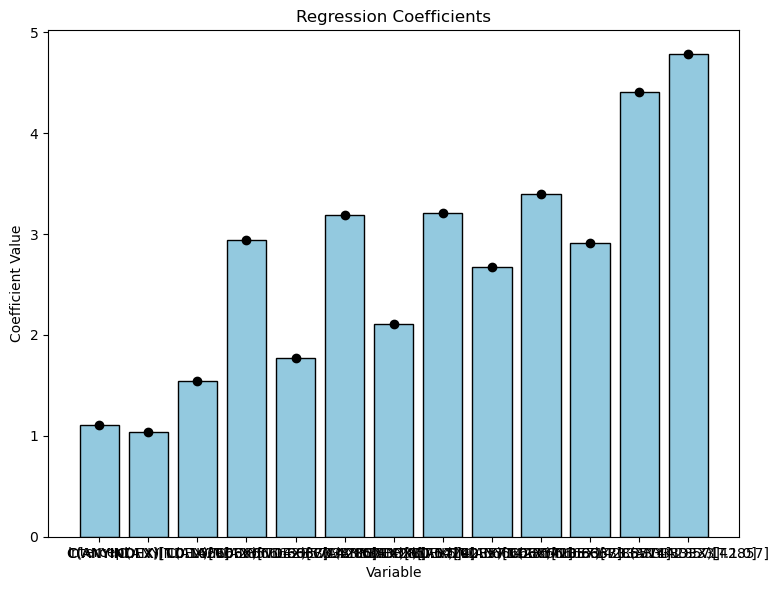

In [10]:
coef = res.params
errors = res.bse

intercept = coef.loc['Intercept']
adjusted_coef = coef.copy()
adjusted_coef[1:] += intercept

coef_df = pd.DataFrame({
    'Coefficient': adjusted_coef.index,
    'Value': adjusted_coef.values,
})

plt.figure(figsize=(8, 6))
sns.barplot(
    data=coef_df, 
    y='Value', 
    x='Coefficient',  
    color='skyblue', 
    edgecolor='black'
)

for i in range(len(coef_df)):
    plt.errorbar(
        coef_df['Coefficient'][i], 
        coef_df['Value'][i], 
        fmt='o', 
        color='black'
    )

plt.title('Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()


Analizując powyższy wykres przedstawiający wartości coef dla DEPRESSIONINDEX ~ ANYINDEX, można zauważyć, że im większe uzależnienie od narkotyków tym osoba ma skłonność do wpadnięcia w głębszą depresję. W środkowej części wykresu widać pewne oscylacje, jednak im większy współczynnik uzależnienia tym one maleją a wartości wzrastają. Patrząc na wyniki z modelu OLS, dla wszystkich segmentów możemy odrzucić hipotezę zerową oprócz wartości ANYINDEX = 0.1429, gdzie p-value = 0.877 co znacząco przekracza graniczną wartość 0.05. Jednak mimo tego widać, że czynnik ANYINDEX ma znaczący wpływ na poziom depresji. 

In [11]:
formula = """
DEPRESSIONINDEX ~ C(IREDUC2)
"""
model = ols(formula=formula, data=filtered_data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     36.61
Date:                Sun, 26 Jan 2025   Prob (F-statistic):           3.65e-72
Time:                        18:30:42   Log-Likelihood:                -89419.
No. Observations:               36972   AIC:                         1.789e+05
Df Residuals:                   36961   BIC:                         1.790e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4486      0.074      6.072      0.000       0.304       0.593
C(IREDUC2)[T.2]      0.2094      0.089      2.361      0.018       0.036       0.383
C(IREDUC2)[T.3]      0.4537      0.088      5.157      0.000       0.281       0.626
C(IREDUC2)[T.4]      0.7988      0.087      9.186      0.000       0.628       0.969
C(IREDUC2)[T.5]      0.8199      0.087      9.468      0.000       0.650       0.990
C(IREDUC2)[T.6]      1.0148      0.087     11.686      0.000       0.845       1.185
C(IREDUC2)[T.7]      0.9336      0.088     10.610      0.000       0.761       1.106
C(IREDUC2)[T.8]      0.8495      0.081     10.453      0.000       0.690       1.009
C(IREDUC2)[T.9]      0.9794      0.096     10.208      0.000       0.791       1.167
C(IREDUC2)[T.10]     0.9976      0.088     11.363      0.000       0.826       1.170
C(IREDUC2)[T.11]     0.8100      0.086      9.380      0.000       0.641       0.979
==============================================================================
Omnibus:                    12098.086   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28854.115
Skew:                           1.916   Prob(JB):                         0.00
Kurtosis:                       5.010   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

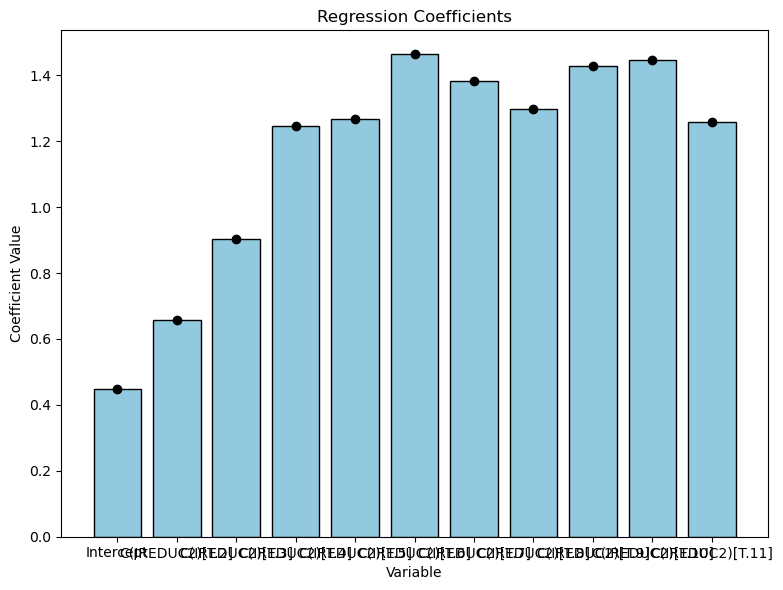

In [12]:
coef = res.params
errors = res.bse

intercept = coef.loc['Intercept']
adjusted_coef = coef.copy()
adjusted_coef[1:] += intercept

coef_df = pd.DataFrame({
    'Coefficient': adjusted_coef.index,
    'Value': adjusted_coef.values,
})

plt.figure(figsize=(8, 6))
sns.barplot(
    data=coef_df, 
    y='Value', 
    x='Coefficient',  
    color='skyblue', 
    edgecolor='black'
)

for i in range(len(coef_df)):
    plt.errorbar(
        coef_df['Coefficient'][i], 
        coef_df['Value'][i], 
        fmt='o', 
        color='black'
    )

plt.title('Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

Analizując powyższy wykres przedstawiający wartości coef dla DEPRESSIONINDEX ~ IREDUC, można zauważyć, że im większe wykształcenie do pewnego momentu, tym osoba ma skłonność do wpadnięcia w głębszą depresję. Następnie od wartości IREDUC2 = 4 ten współczynnik depresji utrzymuje się na równym poziomie z małymi oscylacjami. Patrząc na wyniki z modelu OLS, dla wszystkich segmentów możemy odrzucić hipotezę zerową oprócz wartości IREDUC2 = 2, gdzie p-value = 0.018 co przekracza graniczną wartość 0.05. Jednak mimo tego widać, że czynnik IREDUC2 ma znaczący wpływ na poziom depresji i jest to wartość od tego czynnika zależna

In [13]:
formula = """
DEPRESSIONINDEX ~ C(EMPSTAT4)
"""
model = ols(formula=formula, data=filtered_data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     17.04
Date:                Sun, 26 Jan 2025   Prob (F-statistic):           5.75e-14
Time:                        18:30:45   Log-Likelihood:                -89567.
No. Observations:               36972   AIC:                         1.791e+05
Df Residuals:                   36967   BIC:                         1.792e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.2413      0.028     45.097      0.000       1.187       1.295
C(EMPSTAT4)[T.2]      0.2037      0.054      3.800      0.000       0.099       0.309
C(EMPSTAT4)[T.3]      0.2627      0.086      3.061      0.002       0.094       0.431
C(EMPSTAT4)[T.4]      0.0534      0.050      1.063      0.288      -0.045       0.152
C(EMPSTAT4)[T.99]    -0.1293      0.034     -3.790      0.000      -0.196      -0.062
==============================================================================
Omnibus:                    12302.274   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29751.894
Skew:                           1.942   Prob(JB):                         0.00
Kurtosis:                       5.057   Cond. No.                         7.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

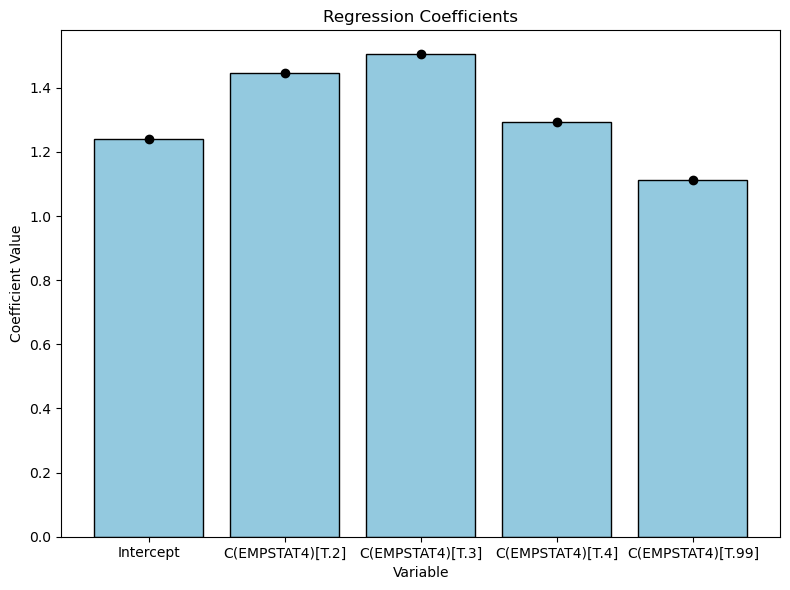

In [14]:
coef = res.params
errors = res.bse

intercept = coef.loc['Intercept']
adjusted_coef = coef.copy()
adjusted_coef[1:] += intercept

coef_df = pd.DataFrame({
    'Coefficient': adjusted_coef.index,
    'Value': adjusted_coef.values,
})

plt.figure(figsize=(8, 6))
sns.barplot(
    data=coef_df, 
    y='Value', 
    x='Coefficient',  
    color='skyblue', 
    edgecolor='black'
)

for i in range(len(coef_df)):
    plt.errorbar(
        coef_df['Coefficient'][i], 
        coef_df['Value'][i], 
        fmt='o', 
        color='black'
    )

plt.title('Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

Analizując powyższy wykres przedstawiający wartości coef dla DEPRESSIONINDEX ~ EMPSTAT4, można zauważyć, że rodzaj zatrudnienia ma wpływ na poziom depresji. Osoby bezrobotne mają większą tendencję do popadania w nią od osób, które pracują na stałe, na pół etatu lub nie były brane pod uwagę w tym pytaniu. Analizując wyniki otrzymane z modelu OLS, wynika że wartość DEPRESSIONINDEX jest zależna od EMPSTAT4 oprócz EMPSTAT4 = 4, gdzie są osoby, których działalność ciężko zdefiniować. Dla tej wartości p-value = 0.288, co uniemożliwia nam odrzucenie hipotezy zerowej, ponieważ nie jesteśmy w jasny sposób określić, czy ta wartość jest ściśle zależna

In [15]:
formula = """
DEPRESSIONINDEX ~ C(ANYTHEFT)
"""
model = ols(formula=formula, data=filtered_data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     109.5
Date:                Sun, 26 Jan 2025   Prob (F-statistic):           1.34e-25
Time:                        18:30:49   Log-Likelihood:                -89547.
No. Observations:               36972   AIC:                         1.791e+05
Df Residuals:                   36970   BIC:                         1.791e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1833      0.014     82.040      0.000       1.155       1.212
C(ANYTHEFT)[T.1]     0.8273      0.079     10.466      0.000       0.672       0.982
==============================================================================
Omnibus:                    12274.824   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29630.044
Skew:                           1.938   Prob(JB):                         0.00
Kurtosis:                       5.051   Cond. No.                         5.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

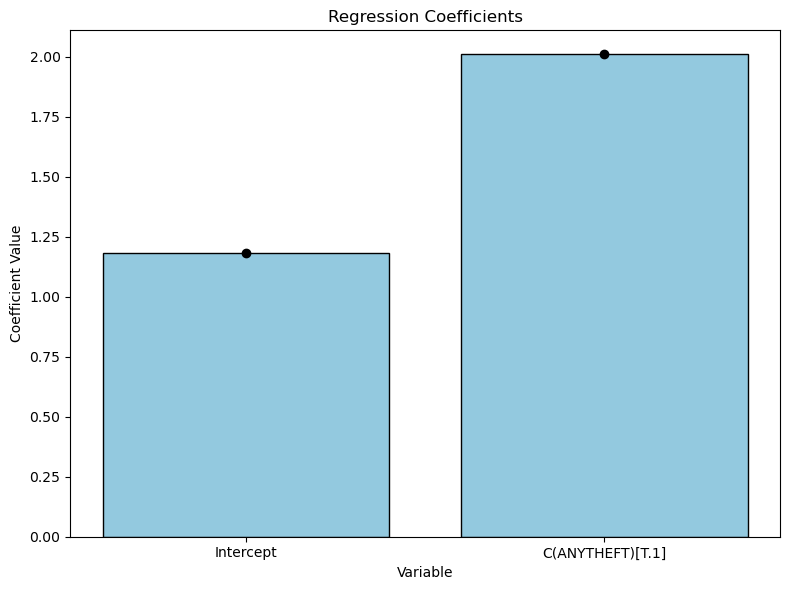

In [16]:
coef = res.params
errors = res.bse

intercept = coef.loc['Intercept']
adjusted_coef = coef.copy()
adjusted_coef[1:] += intercept

coef_df = pd.DataFrame({
    'Coefficient': adjusted_coef.index,
    'Value': adjusted_coef.values,
})

plt.figure(figsize=(8, 6))
sns.barplot(
    data=coef_df, 
    y='Value', 
    x='Coefficient',  
    color='skyblue', 
    edgecolor='black'
)

for i in range(len(coef_df)):
    plt.errorbar(
        coef_df['Coefficient'][i], 
        coef_df['Value'][i], 
        fmt='o', 
        color='black'
    )

plt.title('Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

Analizując powyższy wykres przedstawiający wartości coef dla DEPRESSIONINDEX ~ ANYTHEFT, można zauważyć, że osoby, które popełniły kiedykolwiek jakieś przestępstwo mają większą skłonność do depresji, niż osoby, które nie popełniły żadnego wykroczenia. Analizując model OLS widać, że DEPRESSIONINDEX jest silnie zależne od tego czynnika

In [17]:
formula = """
DEPRESSIONINDEX ~ C(DSTCHEER)
"""
model = ols(formula=formula, data=filtered_data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1026.
Date:                Sun, 26 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:30:55   Log-Likelihood:                -87199.
No. Observations:               36972   AIC:                         1.744e+05
Df Residuals:                   36966   BIC:                         1.745e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.7488      0.090     52.746      0.000       4.572       4.925
C(DSTCHEER)[T.2]     -0.5539      0.111     -4.996      0.000      -0.771      -0.337
C(DSTCHEER)[T.3]     -2.6103      0.101    -25.719      0.000      -2.809      -2.411
C(DSTCHEER)[T.4]     -3.7100      0.098    -37.829      0.000      -3.902      -3.518
C(DSTCHEER)[T.5]     -4.3990      0.094    -46.804      0.000      -4.583      -4.215
C(DSTCHEER)[T.99]    -3.6368      0.092    -39.532      0.000      -3.817      -3.457
==============================================================================
Omnibus:                    11060.513   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26039.775
Skew:                           1.715   Prob(JB):                         0.00
Kurtosis:                       5.266   Cond. No.                         19.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

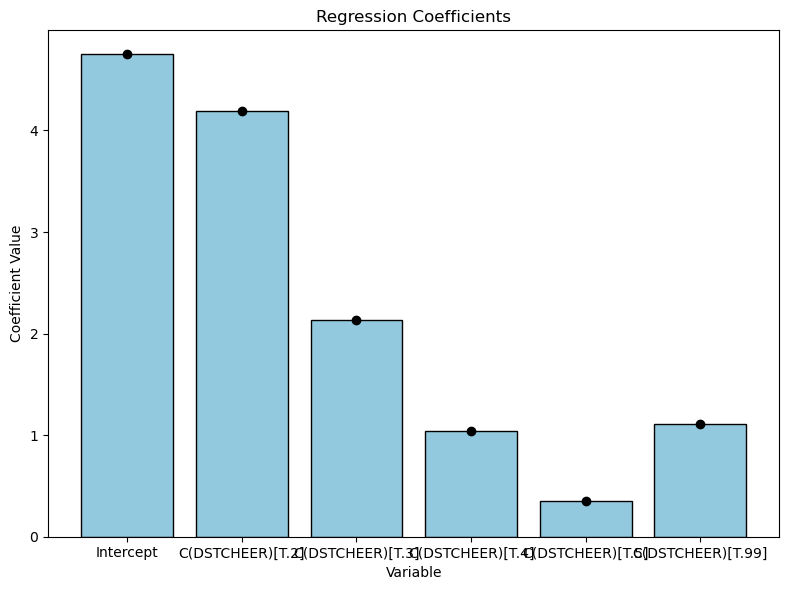

In [18]:
coef = res.params
errors = res.bse

intercept = coef.loc['Intercept']
adjusted_coef = coef.copy()
adjusted_coef[1:] += intercept

coef_df = pd.DataFrame({
    'Coefficient': adjusted_coef.index,
    'Value': adjusted_coef.values,
})

plt.figure(figsize=(8, 6))
sns.barplot(
    data=coef_df, 
    y='Value', 
    x='Coefficient',  
    color='skyblue', 
    edgecolor='black'
)

for i in range(len(coef_df)):
    plt.errorbar(
        coef_df['Coefficient'][i], 
        coef_df['Value'][i], 
        fmt='o', 
        color='black'
    )

plt.title('Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

Analizując powyższy wykres przedstawiający wartości coef dla DEPRESSIONINDEX ~ DSTCHEER, można zauważyć, że im ktoś częściej ma zły humor (nie da się go pocieszyć), tym ma skłonność do głębszej depresji. Jak widać tendencja jest spadkowa co świadczy o tym, że im osoba łatwiej daje się pocieszyć, tym poziom depresji maleje. Wyjątkiem jest wartość DSTCHEER = 99, ale przez to, że oznacza ona Legitimate skip, nie jest ona brana pod uwagę w tej analizie. Patrząc na wyniki z modelu OLS, widać, że cały ten czynnik jest silnie zależny z DEPRESSIONINDEX, ponieważ wartość p-value równa się 0

In [19]:
formula = """
DEPRESSIONINDEX ~ C(HEALTH2)
"""
model = ols(formula=formula, data=filtered_data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     160.8
Date:                Sun, 26 Jan 2025   Prob (F-statistic):          1.38e-103
Time:                        18:30:59   Log-Likelihood:                -89362.
No. Observations:               36972   AIC:                         1.787e+05
Df Residuals:                   36968   BIC:                         1.788e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8478      0.025     33.300      0.000       0.798       0.898
C(HEALTH2)[T.2]     0.3597      0.034     10.618      0.000       0.293       0.426
C(HEALTH2)[T.3]     0.6400      0.039     16.477      0.000       0.564       0.716
C(HEALTH2)[T.4]     1.1401      0.062     18.433      0.000       1.019       1.261
==============================================================================
Omnibus:                    11991.334   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28381.774
Skew:                           1.904   Prob(JB):                         0.00
Kurtosis:                       4.982   Cond. No.                         5.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

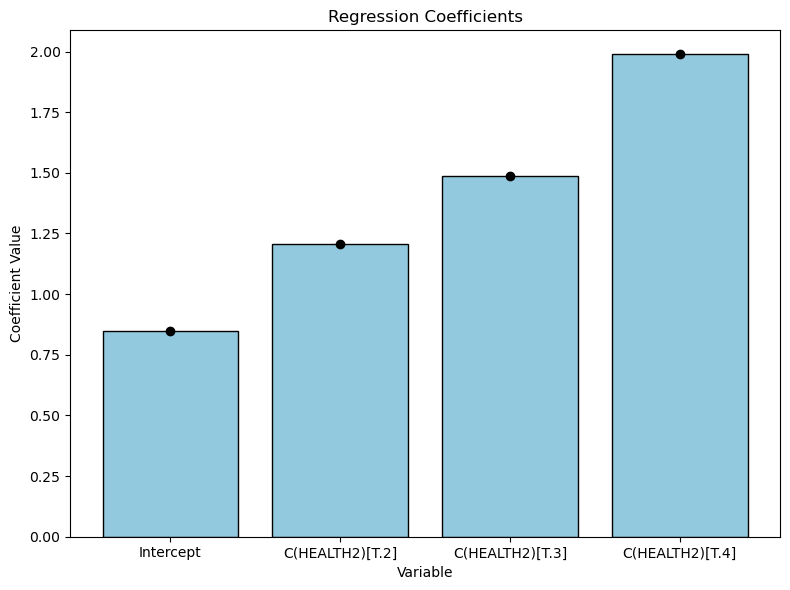

In [20]:
coef = res.params
errors = res.bse

intercept = coef.loc['Intercept']
adjusted_coef = coef.copy()
adjusted_coef[1:] += intercept

coef_df = pd.DataFrame({
    'Coefficient': adjusted_coef.index,
    'Value': adjusted_coef.values,
})

plt.figure(figsize=(8, 6))
sns.barplot(
    data=coef_df, 
    y='Value', 
    x='Coefficient',  
    color='skyblue', 
    edgecolor='black'
)

for i in range(len(coef_df)):
    plt.errorbar(
        coef_df['Coefficient'][i], 
        coef_df['Value'][i], 
        fmt='o', 
        color='black'
    )

plt.title('Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

Analizując powyższy wykres przedstawiający wartości coef dla DEPRESSIONINDEX ~ HEALTH2, można zauważyć, że im gorsze zdrowie tym człowiek ma większą tendencje to popadania w głębszą depresję. Patrząc również na wyniki modelu OLS, widać, że p-value dla wszystkich segmentów jest równe 0, co oznacza że czynnik HEALTH2 jest istotny dla DEPRESSIONINDEX

In [21]:
formula = """
DEPRESSIONINDEX ~ C(IRMARIT)
"""
model = ols(formula=formula, data=filtered_data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     115.8
Date:                Sun, 26 Jan 2025   Prob (F-statistic):           2.41e-98
Time:                        18:31:02   Log-Likelihood:                -89371.
No. Observations:               36972   AIC:                         1.788e+05
Df Residuals:                   36967   BIC:                         1.788e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0687      0.032     33.485      0.000       1.006       1.131
C(IRMARIT)[T.2]      0.1715      0.134      1.283      0.199      -0.091       0.434
C(IRMARIT)[T.3]      1.0668      0.073     14.573      0.000       0.923       1.210
C(IRMARIT)[T.4]      0.3027      0.038      8.035      0.000       0.229       0.376
C(IRMARIT)[T.99]    -0.2396      0.043     -5.618      0.000      -0.323      -0.156
==============================================================================
Omnibus:                    12086.885   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28845.621
Skew:                           1.913   Prob(JB):                         0.00
Kurtosis:                       5.023   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

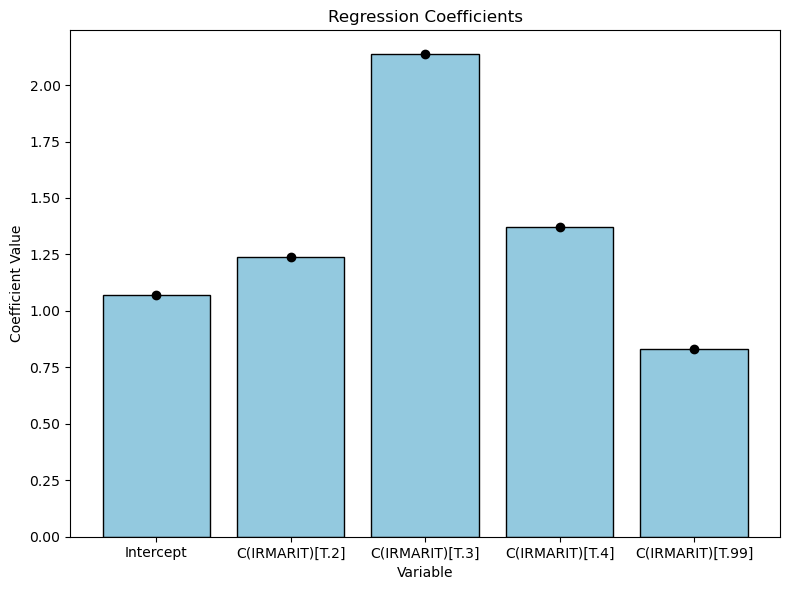

In [22]:
coef = res.params
errors = res.bse

intercept = coef.loc['Intercept']
adjusted_coef = coef.copy()
adjusted_coef[1:] += intercept

coef_df = pd.DataFrame({
    'Coefficient': adjusted_coef.index,
    'Value': adjusted_coef.values,
})

plt.figure(figsize=(8, 6))
sns.barplot(
    data=coef_df, 
    y='Value', 
    x='Coefficient',  
    color='skyblue', 
    edgecolor='black'
)

for i in range(len(coef_df)):
    plt.errorbar(
        coef_df['Coefficient'][i], 
        coef_df['Value'][i], 
        fmt='o', 
        color='black'
    )

plt.title('Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

Analizując powyższy wykres przedstawiający wartości coef dla DEPRESSIONINDEX ~ IRMARIT, można zauważyć że osoby, które są rozwiedzione mają większe skłonności do popadania w glębszą depresję niż pozostałe grupy. Widać również, że osoby, które są po ślubie są mniej narażone na depresję niż osoby, które nigdy nie wzięły ślubu. Analizując wyniki z modelu OLS, możemy stwiedzić, że możemy odrzucić hipotezę zerową i powiedzieć, że IRMARIT jest istotne w analizie DEPRESSIONINDEX

### Finalny zbiór danych

In [23]:
final_selected_columns = [
    'DEPRESSIONINDEX', 'CATAG2', 'IRSEX', 'SOMA',

    'ANYINDEX', 'IREDUC2', 'EMPSTAT4', 'ANYTHEFT',
    'DSTCHEER', 'HEALTH2', 'IRMARIT'
]

In [24]:
final_data = filtered_data[final_selected_columns]
print(final_data.shape[0])
print(final_data.shape[1])

36972
11


### Stosując znane Ci metody oceny istotności, przeanalizuj jak wybrane czynniki zmieniają się w zależności od grupy wiekowej i od płci, możesz również sprawdzić czy istnieją istotne zmiany dla typu depresji (somatycznej i niesomatycznej).

Do oceny istotności, jak czynniki zmieniają się w zależności od grupy wiekowej i płci, a także od typu depresji (somatyczna i niesomatyczna) wybrałem test chi-kwadrat.

##### DSTCHEER

In [25]:
table = pd.crosstab(final_data['DSTCHEER'], final_data['CATAG2'])
print(table)

chi2, p, dof, expected = chi2_contingency(table)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

CATAG2        1     2     3
DSTCHEER                   
1             0   538   270
2             0  1012   553
3             0  1636  1347
4             0  2255  2074
5             0  3928  5064
99        18294     0     1
Chi2-statistic: 37764.52563153106
p-value: 0.0
Degrees of freedom: 10
Expected frequencies:
 [[ 399.80395975  204.75365141  203.44238883]
 [ 774.37276858  396.58349562  394.0437358 ]
 [1476.00892567  755.91601753  751.0750568 ]
 [2142.01898734 1097.00316456 1089.9778481 ]
 [4449.3034729  2278.64459591 2264.05193119]
 [9052.49188575 4636.09907498 4606.40903927]]


Jak można powyżej zauważyć, dla CATAG = 1 występuje tylko jedna wartość DSTCHEER = 99 i to liczbie 18294 (cała młodzież). Widać, że taka sytuacja mocno wpływa na ostateczny wynik chi-kwadrat, dlatego dla tego przypadku, nie będę brał CATAG = 1 pod uwagę i pod spodem przedstawiam dalszą analizę DSTCHEER

In [26]:
temp_data = final_data[final_data['CATAG2'].isin([2, 3])]
temp_table = pd.crosstab(temp_data['DSTCHEER'], temp_data['CATAG2'])
print(temp_table)

chi2, p, dof, expected = chi2_contingency(temp_table)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

CATAG2       2     3
DSTCHEER            
1          538   270
2         1012   553
3         1636  1347
4         2255  2074
5         3928  5064
99           0     1
Chi2-statistic: 403.4057661587429
p-value: 5.472786936529582e-85
Degrees of freedom: 5
Expected frequencies:
 [[4.05297783e+02 4.02702217e+02]
 [7.85013652e+02 7.79986348e+02]
 [1.49629120e+03 1.48670880e+03]
 [2.17145310e+03 2.15754690e+03]
 [4.51044266e+03 4.48155734e+03]
 [5.01606168e-01 4.98393832e-01]]


- Chi2-statistic: 403.4057661587429 - wynik wskazuje na istotne różnice między obserwowalnymi a oczekiwanymi wartościami,

- p-value: 5.472786936529582e-85 - p (<0.05), odrzucamy hipotezę zerową, istnieje istotny statystycznie związek między DSTCHEER a CATAG2 w grupach wiekowych 18-25 oraz 26+

- dla DSTCHEER = 1 - CATAG2 = 2 ma większy udział w tej kategorii niż CATAG2 = 3

- dla DSTCHEER = 2 - CATAG2 = 2 ma większy udział w tej kategorii niż CATAG2 = 3

- dla DSTCHEER = 3 - CATAG2 = 2 ma większy udział w tej kategorii niż CATAG2 = 3

- dla DSTCHEER = 4 - CATAG2 = 2 ma większy udział w tej kategorii niż CATAG2 = 3

- dla DSTCHEER = 5 - CATAG2 = 3 ma większy udział w tej kategorii niż CATAG2 = 2

In [27]:
table1 = pd.crosstab(final_data['DSTCHEER'], final_data['IRSEX'])
print(table1)

chi2, p, dof, expected = chi2_contingency(table1)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

IRSEX        1     2
DSTCHEER            
1          279   529
2          568   997
3         1161  1822
4         1887  2442
5         4754  4238
99        9330  8965
Chi2-statistic: 421.97339019348095
p-value: 5.438421816704378e-89
Degrees of freedom: 5
Expected frequencies:
 [[ 392.91983122  415.08016878]
 [ 761.03902954  803.96097046]
 [1450.59388186 1532.40611814]
 [2105.13607595 2223.86392405]
 [4372.69198312 4619.30801688]
 [8896.61919831 9398.38080169]]


- Chi2-statistic: 421.97339019348095 - wynik wskazuje na istotne różnice między obserwowalnymi a oczekiwanymi wartościami

- p-value: 5.438421816704378e-89 - p (<0.05), odrzucamy hipotezę zerową, istnieje istotny statystycznie związek między DSTCHEER a IRSEX

- rozkład DSTCHEER różni się w zależności od płci

- np. dla DSTCHEER = 1 i IRSEX = 1 spodziewano się większego udziału mężczyzn, natomiast dla DSTCHEER = 1 i IRSEX = 2 oczekiwano mniejszego udziału kobiet

In [28]:

table2 = pd.crosstab(final_data['DSTCHEER'], final_data['SOMA'])
print(table2)

chi2, p, dof, expected = chi2_contingency(table2)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

SOMA        0     1      99
DSTCHEER                   
1           75   410    323
2          158   721    686
3          215   693   2075
4          218   470   3641
5          172   328   8492
99        1171  1753  15371
Chi2-statistic: 4523.224050255664
p-value: 0.0
Degrees of freedom: 10
Expected frequencies:
 [[   43.90544196    95.61289625   668.4816618 ]
 [   85.03962458   185.19082008  1294.76955534]
 [  162.09150168   352.98671968  2467.92177864]
 [  235.23101266   512.26265823  3581.50632911]
 [  488.61105702  1064.04846911  7439.34047387]
 [  994.12136211  2164.89843665 15135.98020123]]


Ze względu na dużą liczbę wartości 99 dla DSTCHEER i SOMA w dalszej analizie związku miedzy DSTCHEER a SOMA nie będę uwzględniać tej wartości

In [29]:
temp_data2 = final_data[(final_data['DSTCHEER'].isin([1, 2, 3, 4, 5])) & (final_data['SOMA'].isin([0, 1]))]
table2 = pd.crosstab(temp_data2['DSTCHEER'], temp_data2['SOMA'])
print(table2)

chi2, p, dof, expected = chi2_contingency(table2)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

SOMA        0    1
DSTCHEER          
1          75  410
2         158  721
3         215  693
4         218  470
5         172  328
Chi2-statistic: 88.21021632813995
p-value: 3.1595165107931545e-18
Degrees of freedom: 4
Expected frequencies:
 [[117.46531792 367.53468208]
 [212.89075145 666.10924855]
 [219.91445087 688.08554913]
 [166.63121387 521.36878613]
 [121.0982659  378.9017341 ]]


- Chi2-statistic: 88.21021632813995 - wynik sugeruje istotne różnice między obserwowanymi a oczekiwanymi wartościami

- p-value: 3.1595165107931545e-18 - odrzucamy hipotezę zerową, istnieje istotny związek między DSTCHEER a SOMA

- osoby mające depresję somatyczną (1), a niesomatyczną (0) różnią się pod względem DSTCHEER

##### ANYINDEX

In [30]:
table3 = pd.crosstab(final_data['ANYINDEX'], final_data['CATAG2'])
print(table3)

chi2, p, dof, expected = chi2_contingency(table3)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

CATAG2        1     2     3
ANYINDEX                   
0.142857  16658  7896  8899
0.142900     19     4     6
0.166667    554   471   134
0.285714    100    69    33
0.333333    424   373    64
0.428571     51    43    19
0.500000    207   188    36
0.571429     44    45    23
0.666667    123   114    20
0.714286     25    38    25
0.833333     57    57    11
0.857143     13    38    23
1.000000     19    33    16
Chi2-statistic: 800.8944278533243
p-value: 1.3393447033243768e-153
Degrees of freedom: 24
Expected frequencies:
 [[1.65527746e+04 8.47725730e+03 8.42296811e+03]
 [1.43493995e+01 7.34883155e+00 7.30176891e+00]
 [5.73481175e+02 2.93699854e+02 2.91818971e+02]
 [9.99509899e+01 5.11884129e+01 5.08605972e+01]
 [4.26028724e+02 2.18184275e+02 2.16787001e+02]
 [5.59131775e+01 2.86351022e+01 2.84517202e+01]
 [2.13261766e+02 1.09218841e+02 1.08519393e+02]
 [5.54183707e+01 2.83816943e+01 2.81999351e+01]
 [1.27165368e+02 6.51258520e+01 6.47087796e+01]
 [4.35430055e+01 2.22999026e+01 2.2

- Chi2-statistic: 800.8944278533243 - silny związek między ANYINDEX a CATAG2, rozkład ANYINDEX różni się między grupami CATAG2

- p-value: 1.3393447033243768e-153 - odrzucamy hipotezę zerową, istnieje silny związek między ANYINDEX a CATAG2

- w przypadku większości kategorii, obserwowane wartości są zbliżone do przewidywanych, co potwierdza, że wyniki testu chi-kwadrat są rzetelne

In [275]:
table4 = pd.crosstab(final_data['ANYINDEX'], final_data['IRSEX'])
print(table4)

chi2, p, dof, expected = chi2_contingency(table4)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

IRSEX         1      2
ANYINDEX              
0.142857  16023  17430
0.142900     17     12
0.166667    676    483
0.285714     74    128
0.333333    521    340
0.428571     46     67
0.500000    248    183
0.571429     51     61
0.666667    134    123
0.714286     50     38
0.833333     67     58
0.857143     34     40
1.000000     38     30
Chi2-statistic: 135.7367055327653
p-value: 4.335191254650873e-23
Degrees of freedom: 12
Expected frequencies:
 [[1.62677563e+04 1.71852437e+04]
 [1.41023207e+01 1.48976793e+01]
 [5.63606540e+02 5.95393460e+02]
 [9.82299578e+01 1.03770042e+02]
 [4.18693038e+02 4.42306962e+02]
 [5.49504219e+01 5.80495781e+01]
 [2.09589662e+02 2.21410338e+02]
 [5.44641350e+01 5.75358650e+01]
 [1.24975738e+02 1.32024262e+02]
 [4.27932489e+01 4.52067511e+01]
 [6.07858650e+01 6.42141350e+01]
 [3.59852321e+01 3.80147679e+01]
 [3.30675105e+01 3.49324895e+01]]


- Chi2-statistic: 135.7367055327653 - istnieje istotny związek między ANYINDEX a IRSEX, rozkład ANYINDEX różni się między mężczyznami a kobietami

- p-value: 4.335191254650873e-23 - odrzucamy hipotezę zerową, istnieje istotna zależność między cechami

- przewidywane wartości są zbliżone do obserwowanych, co wskazuje na wiarygodność testu chi-kwadrat i dobrze dopasowaną tabelę kontyngencji

In [31]:
# Odrzucamy wartość 99 dla SOMA żeby przeanalizować tylko 
# te osoby które mają depresję somatyczną albo niesomatyczną
temp_data5 = final_data[final_data['SOMA'].isin([0, 1])]
table5 = pd.crosstab(temp_data5['ANYINDEX'], temp_data5['SOMA'])
print(table5)

chi2, p, dof, expected = chi2_contingency(table5)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

SOMA         0     1
ANYINDEX            
0.142857  1747  3633
0.142900     2     2
0.166667    65   179
0.285714    13    64
0.333333    68   145
0.428571    14    31
0.500000    37    80
0.571429     8    37
0.666667    22    69
0.714286     3    35
0.833333    13    34
0.857143     5    37
1.000000    12    29
Chi2-statistic: 37.217382398750345
p-value: 0.00020597609208519542
Degrees of freedom: 12
Expected frequencies:
 [[1.69304825e+03 3.68695175e+03]
 [1.25877193e+00 2.74122807e+00]
 [7.67850877e+01 1.67214912e+02]
 [2.42313596e+01 5.27686404e+01]
 [6.70296053e+01 1.45970395e+02]
 [1.41611842e+01 3.08388158e+01]
 [3.68190789e+01 8.01809211e+01]
 [1.41611842e+01 3.08388158e+01]
 [2.86370614e+01 6.23629386e+01]
 [1.19583333e+01 2.60416667e+01]
 [1.47905702e+01 3.22094298e+01]
 [1.32171053e+01 2.87828947e+01]
 [1.29024123e+01 2.80975877e+01]]


- Chi2-statistic: 37.217382398750345 - istnieje istotny związek między ANYINDEX a SOMA

- p-value: 0.00020597609208519542 - odrzucamy hipoteze zerową

##### HEALTH2


In [32]:
table6 = pd.crosstab(final_data['HEALTH2'], final_data['CATAG2'])
print(table6)

chi2, p, dof, expected = chi2_contingency(table6)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

CATAG2      1     2     3
HEALTH2                  
1        6207  2773  2376
2        7645  3846  3254
3        3803  2239  2512
4         639   511  1167
Chi2-statistic: 1147.4405648456518
p-value: 1.1332652060546699e-244
Degrees of freedom: 6
Expected frequencies:
 [[5619.02693931 2877.70107108 2859.27198961]
 [7295.92745862 3736.50073028 3712.5718111 ]
 [4232.57805907 2167.65189873 2153.77004219]
 [1146.46754301  587.1462999   583.38615709]]


- Chi2-statistic: 1147.4405648456518 - istnieje silna zależność między HEALTH2 a CATAG2

- p-value: 1.1332652060546699e-244 - odrzucamy hipotezę zerową

- z tabeli kontyngnecji możemy zauważyć że im osoba starsza tym jej zdrowie się pogarsza

- różnice między wartościami zaobserwowanymi a oczekiwanymi wynikają z dużej wartości Chic2

In [33]:
table7 = pd.crosstab(final_data['HEALTH2'], final_data['IRSEX'])
print(table7)

chi2, p, dof, expected = chi2_contingency(table7)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

IRSEX       1     2
HEALTH2            
1        5655  5701
2        7195  7550
3        4083  4471
4        1046  1271
Chi2-statistic: 20.38713279381717
p-value: 0.00014110010667897673
Degrees of freedom: 3
Expected frequencies:
 [[5522.2742616  5833.7257384 ]
 [7170.30063291 7574.69936709]
 [4159.69831224 4394.30168776]
 [1126.72679325 1190.27320675]]


- Chi2-statistic: 20.38713279381717 - istnieje zależność między HEALTH2 a IRSEX

- p-value: 0.00014110010667897673 - odrzucamy hipotezę zerową, istnieje zależność między HEALTH2 a IRSEX

- z tabeli można zauważyć, że przewidywane wartości pokrywaja się z zanotowanymi, a także że kobiety mają tendencje to posiadania gorszego zdrowia

In [34]:
# Odrzucamy wartość 99 dla SOMA żeby przeanalizować tylko 
# te osoby które mają depresję somatyczną albo niesomatyczną
temp_data8 = final_data[final_data['SOMA'].isin([0, 1])]
table8 = pd.crosstab(temp_data8['HEALTH2'], temp_data8['SOMA'])
print(table8)

chi2, p, dof, expected = chi2_contingency(table8)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

SOMA       0     1
HEALTH2           
1        535   908
2        847  1710
3        500  1272
4        127   485
Chi2-statistic: 65.56900706877083
p-value: 3.789994587869421e-14
Degrees of freedom: 3
Expected frequencies:
 [[ 454.10197368  988.89802632]
 [ 804.66995614 1752.33004386]
 [ 557.63596491 1214.36403509]
 [ 192.59210526  419.40789474]]


- Chi2-statistic: 65.56900706877083 - istnieje zależność między HEALTH2 a SOMA

- p-value: 3.789994587869421e-14 - bardzo mała wartość (p<0.05) odrzucamy hipotezę zerową

- wartości oczekiwane pokrywają się z zanotowanymi

- osoby mające depresję somatyczną czują się gorzej

##### EMPSTAT4

In [35]:
# Odrzucam wartość 1 w CATAG2, ponieważ w tej kategorii młodzież nie brała
# udziału i dla EMPSTAT = 99 i CATAG2 = 1 komórka przyjmuje wartość
# 18294 
temp_data9 = final_data[final_data['CATAG2'].isin([2, 3])]
table9 = pd.crosstab(temp_data9['EMPSTAT4'], temp_data9['CATAG2'])
print(table9)

chi2, p, dof, expected = chi2_contingency(table9)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

CATAG2       2     3
EMPSTAT4            
1         4104  5721
2         2447  1072
3          790   337
4         2028  2179
Chi2-statistic: 990.7096673808658
p-value: 1.864146807039813e-214
Degrees of freedom: 3
Expected frequencies:
 [[4928.28059749 4896.71940251]
 [1765.15210408 1753.84789592]
 [ 565.31015098  561.68984902]
 [2110.25714745 2096.74285255]]


- Chi2-statistic: 990.7096673808658 - istnieje silna zależność między EMPSTAT4 a CATAG2 dla grupy 18-25 i 26+

- p-value: 1.864146807039813e-214 - odrzucamy hipotezę zerową

- można zauważyć że osoby z przedziału 18-25 cześciej są nie zatrudnione i częściej pracują na część etatu (part time)

- jest duża różnica między tym, co zaobserwowano, a tym co było oczekiwane (duże Chic2)

In [36]:
table10 = pd.crosstab(final_data['EMPSTAT4'], final_data['IRSEX'])
print(table10)

chi2, p, dof, expected = chi2_contingency(table10)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

IRSEX        1     2
EMPSTAT4            
1         5307  4518
2         1313  2206
3          568   559
4         1461  2746
99        9330  8964
Chi2-statistic: 662.5504707851796
p-value: 4.471891441040355e-142
Degrees of freedom: 4
Expected frequencies:
 [[4777.76898734 5047.23101266]
 [1711.24367089 1807.75632911]
 [ 548.04535865  578.95464135]
 [2045.80907173 2161.19092827]
 [8896.13291139 9397.86708861]]


- Chi2-statistic: 662.5504707851796 - istnieje zależność między EMPSTAT4 a IRSEX

- p-value: 4.471891441040355e-142 - odrzucamy hipotezę zerową

- mężczyźni częściej pracują na pełen etat niż kobiety, natomiast kobiety częściej mają pracę part-time lub zajmują się czyms innym

In [37]:
# Odrzucamy wartość 99 dla SOMA żeby przeanalizować tylko 
# te osoby które mają depresję somatyczną albo niesomatyczną
temp_data11 = final_data[final_data['SOMA'].isin([0, 1])]
table11 = pd.crosstab(temp_data11['EMPSTAT4'], temp_data11['SOMA'])
print(table11)

chi2, p, dof, expected = chi2_contingency(table11)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

SOMA         0     1
EMPSTAT4            
1          424  1313
2          180   551
3           60   179
4          174   579
99        1171  1753
Chi2-statistic: 184.70272655248624
p-value: 7.285061082663915e-39
Degrees of freedom: 4
Expected frequencies:
 [[ 546.62171053 1190.37828947]
 [ 230.04057018  500.95942982]
 [  75.21162281  163.78837719]
 [ 236.96381579  516.03618421]
 [ 920.1622807  2003.8377193 ]]


- Chi2-statistic: 184.70272655248624 - istnieje zależność między EMPSTAT4 a SOMA, wysoka wartość może świadczyć o tym, ze wyniki oczekiwane będą róznić się od tych zaobserwowanych

- p-value: 7.285061082663915e-39 - odrzucamy hipoteze zerową, istnieje zalezność między EMPSTAT4 a SOMA

##### ANYTHEFT

In [38]:
table12 = pd.crosstab(final_data['ANYTHEFT'], final_data['CATAG2'])
print(table12)

chi2, p, dof, expected = chi2_contingency(table12)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

CATAG2        1     2     3
ANYTHEFT                   
0         17397  9101  9243
1           897   268    66
Chi2-statistic: 345.77670454880706
p-value: 8.232706291545191e-76
Degrees of freedom: 2
Expected frequencies:
 [[17684.89272963  9057.05477118  8999.05249919]
 [  609.10727037   311.94522882   309.94750081]]


- Chi2-statistic: 345.77670454880706 - istnieje związek między ANYTHEFT a CATAG2

- p-value: 8.232706291545191e-76 - odrzucamy hipotezę zerową

- im człowiek starszy tym rzadziej popełnia jakieś przestępstwo

In [39]:
table13 = pd.crosstab(final_data['ANYTHEFT'], final_data['IRSEX'])
print(table13)

chi2, p, dof, expected = chi2_contingency(table13)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

IRSEX         1      2
ANYTHEFT              
0         17211  18530
1           768    463
Chi2-statistic: 95.93907875100956
p-value: 1.1847359663553216e-22
Degrees of freedom: 1
Expected frequencies:
 [[17380.38080169 18360.61919831]
 [  598.61919831   632.38080169]]


- Chi2-statistic: 95.93907875100956 - istnieje związek między ANYTHEFT a IRSEX. Dla ANYTHEFT oczekiwano mniejszy udział mężczyzn w popełnianiu przestępstwa oraz oczekiwana większego udziału kobiet

- p-value: 1.1847359663553216e-22 - odrzucamy hipoteze zerową, istnieje zależność między tymi kategoriami

In [40]:
temp_data14 = final_data[final_data['SOMA'].isin([0, 1])]
table14 = pd.crosstab(temp_data14['ANYTHEFT'], temp_data14['SOMA'])
print(table14)

chi2, p, dof, expected = chi2_contingency(table14)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

SOMA         0     1
ANYTHEFT            
0         1901  4144
1          108   231
Chi2-statistic: 0.009691168941764602
p-value: 0.9215799478816533
Degrees of freedom: 1
Expected frequencies:
 [[1902.31907895 4142.68092105]
 [ 106.68092105  232.31907895]]


- Chi2-statistic: 0.009691168941764602 - niska wartość, oznacza, że różnice między obserwowanymi a oczekiwanymi wartościami są minimalne. Zatem obie te cechy są niemal niezalene od siebie

- p-value: 0.9215799478816533 - p > 0.05, zatem nie ma wystarczających dowodów, by odrzucić hipotezę zetową o braku zależności między ANYTHEFT a SOMA

- Kradzież nie wydaje się mieć związku z występowaniem depresji somatycznej lub niesomatycznej

##### IRMARIT

In [41]:
# Odrzucam CATAG2 = 1 ponieważ ta cecha dotyczy głównie dorosłych, a 
# młodzież mogłaby zakłócać wyniki
temp_data15 = final_data[final_data['CATAG2'].isin([2, 3])]
table15 = pd.crosstab(temp_data15['IRMARIT'], temp_data15['CATAG2'])
print(table15)

chi2, p, dof, expected = chi2_contingency(table15)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

CATAG2      2     3
IRMARIT            
1        1509  5704
2           7   430
3         216  1478
4        7637  1697
Chi2-statistic: 7569.382245842245
p-value: 0.0
Degrees of freedom: 3
Expected frequencies:
 [[3618.0852875  3594.9147125 ]
 [ 219.20189528  217.79810472]
 [ 849.72084806  844.27915194]
 [4681.99196916 4652.00803084]]


 - Chi2-statistic: 7569.382245842245 - istnieje zależność między IRMARIT a CATAG2, ale przez dużą wartość wyniki oczekiwane znacznie odbiegają od obserwowanych

 - p-value: 0.0 - odrzucamy hipotezę zerową, silna zależność

In [42]:
table16 = pd.crosstab(final_data['IRMARIT'], final_data['IRSEX'])
print(table16)

chi2, p, dof, expected = chi2_contingency(table16)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

IRSEX       1     2
IRMARIT            
1        3246  3984
2          84   353
3         614  1083
4        9373  9036
99       4662  4537
Chi2-statistic: 350.85604331586205
p-value: 1.1458975398368322e-74
Degrees of freedom: 4
Expected frequencies:
 [[3515.85443038 3714.14556962]
 [ 212.50738397  224.49261603]
 [ 825.22890295  871.77109705]
 [8952.05590717 9456.94409283]
 [4473.35337553 4725.64662447]]


 - Chi2-statistic: 350.85604331586205 - istnieje zależność między IRMARIT a IRSEX, ale przez dużą wartość wyniki oczekiwane znacznie odbiegają od obserwowanych

 - p-value: 1.1458975398368322e-74 - odrzucamy hipotezę zerową, silna zależność

 - kobiety częściej się rozwodzą od mężczyzn, tak samo częściej są wdowami i częściej biorą ślub

In [43]:
temp_data17 = final_data[final_data['SOMA'].isin([0, 1])]
table17 = pd.crosstab(temp_data17['IRMARIT'], temp_data17['SOMA'])
print(table17)

chi2, p, dof, expected = chi2_contingency(table17)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

SOMA        0     1
IRMARIT            
1         271   830
2          13    62
3          78   414
4        1181  2435
99        466   634
Chi2-statistic: 149.48782163132427
p-value: 2.6210765309064217e-31
Degrees of freedom: 4
Expected frequencies:
 [[ 346.47697368  754.52302632]
 [  23.60197368   51.39802632]
 [ 154.82894737  337.17105263]
 [1137.92982456 2478.07017544]
 [ 346.1622807   753.8377193 ]]


- Chi2-statistic: 149.48782163132427 - istnieje zależność między IRMARIT a SOMA, duża wartość - duże rozbieżności między przewidywaniami a obserwacjami

- p-value: 2.6210765309064217e-31 - odrzucenie hipitezy zerowej

- osoby mające zarówno depresje somatyczną i niesomatyczną rzadziej biorą ślub

##### IREDUC2

In [44]:
table18 = pd.crosstab(final_data['IREDUC2'], final_data['CATAG2'])
print(table18)

chi2, p, dof, expected = chi2_contingency(table18)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

CATAG2      1     2     3
IREDUC2                  
1        1177    58   118
2        2861    75   137
3        3171    20    46
4        3248   101   163
5        3107   269   243
6        2811   408   326
7        1709  1064   461
8         194  3277  2976
9          14  1219   739
10          2  1756  1525
11          0  1122  2575
Chi2-statistic: 27868.645406169784
p-value: 0.0
Degrees of freedom: 20
Expected frequencies:
 [[ 669.47370983  342.86100292  340.66528724]
 [1520.54154495  778.72273612  773.73571892]
 [1601.68987342  820.28164557  815.02848101]
 [1737.76176566  889.96884129  884.26939305]
 [1790.70610191  917.08349562  911.21040247]
 [1754.09039273  898.33130477  892.5783025 ]
 [1600.20545278  819.52142162  814.27312561]
 [3190.01996105 1633.72127556 1623.25876339]
 [ 975.7591691   499.72054528  496.52028562]
 [1624.45098994  831.93841285  826.61059721]
 [1829.30103862  936.8493184   930.84964297]]


- Chi2-statistic: 27868.645406169784 - duża wartość świadczy o tym że przewidywane wartości bedą się różnić od tych zaobserwowanych

- p-value: 0.0 - odrzucamy hipoteze zerową, istnieje silna zależność między IREDUC2 a CATAG2

In [45]:
table19 = pd.crosstab(final_data['IREDUC2'], final_data['IRSEX'])
print(table19)

chi2, p, dof, expected = chi2_contingency(table19)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

IRSEX       1     2
IREDUC2            
1         758   595
2        1581  1492
3        1643  1594
4        1774  1738
5        1853  1766
6        1794  1751
7        1621  1613
8        2953  3494
9         834  1138
10       1469  1814
11       1699  1998
Chi2-statistic: 150.96082848352674
p-value: 2.36436988345061e-27
Degrees of freedom: 10
Expected frequencies:
 [[ 657.94620253  695.05379747]
 [1494.35970464 1578.64029536]
 [1574.11075949 1662.88924051]
 [1707.83966245 1804.16033755]
 [1759.87236287 1859.12763713]
 [1723.8871308  1821.1128692 ]
 [1572.65189873 1661.34810127]
 [3135.09177215 3311.90822785]
 [ 958.95780591 1013.04219409]
 [1596.47995781 1686.52004219]
 [1797.80274262 1899.19725738]]


- Chi2-statistic: 150.96082848352674 - duża wartość świadczy o tym że przewidywane wartości bedą się różnić od tych zaobserwowanych

- p-value: 2.36436988345061e-27 - odrzucamy hipoteze zerową, istnieje silna zależność między IREDUC2 a CATAG2

In [46]:
temp_data20 = final_data[final_data['SOMA'].isin([0, 1])]
table20 = pd.crosstab(temp_data20['IREDUC2'], temp_data20['SOMA'])
print(table20)

chi2, p, dof, expected = chi2_contingency(table20)

print("Chi2-statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

SOMA       0    1
IREDUC2          
1         34   52
2        138  169
3        170  243
4        243  377
5        249  401
6        257  477
7        197  438
8        279  907
9         88  307
10       156  518
11       198  486
Chi2-statistic: 155.8969623608529
p-value: 2.2750641595667887e-28
Degrees of freedom: 10
Expected frequencies:
 [[ 27.06359649  58.93640351]
 [ 96.61074561 210.38925439]
 [129.96820175 283.03179825]
 [195.10964912 424.89035088]
 [204.5504386  445.4495614 ]
 [230.98464912 503.01535088]
 [199.83004386 435.16995614]
 [373.22587719 812.77412281]
 [124.30372807 270.69627193]
 [212.10307018 461.89692982]
 [215.25       468.75      ]]


- Chi2-statistic: 155.8969623608529 - duża wartość świadczy o tym że różnice między obserwacjami a przewidywaniami są istotne, istnieje zależność między nimi

- p-value: 2.2750641595667887e-28 - możemy odrzucić hipiteze zerową, istnieje istotna zależność

- im człowiek bardziej wyedukowany tym szansa na depresje somatyczną lub niesomatyczą rośnie tak do 8 stopnia

##### Poziom depresji w zależności od wybranej cechy a płci, wieku

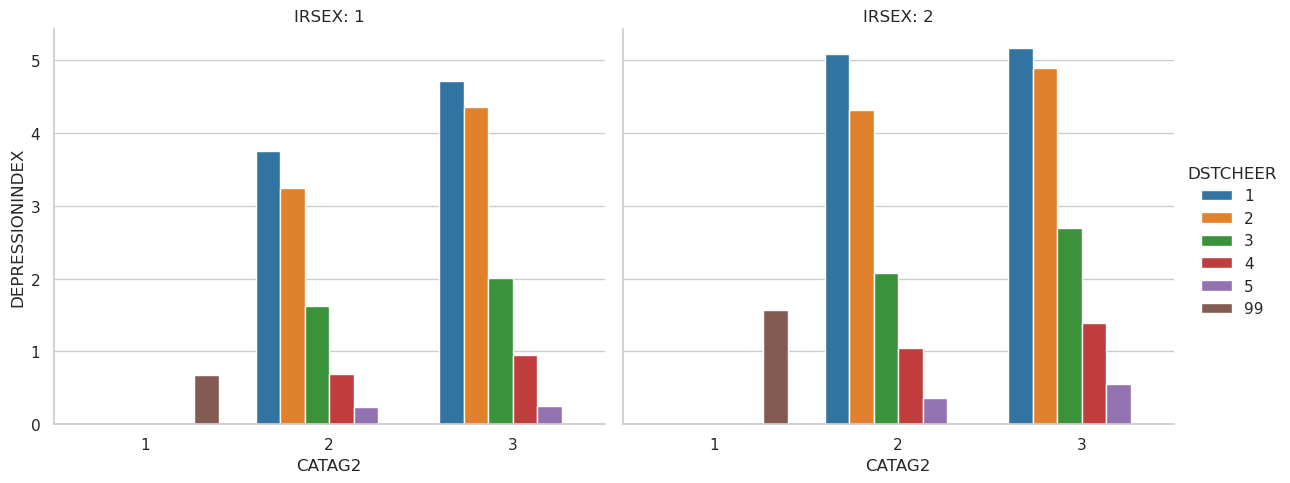

In [47]:
grouped_data = (
    final_data.groupby(['CATAG2', 'DSTCHEER', 'IRSEX'], as_index=False)
    .agg({'DEPRESSIONINDEX': 'mean'})
)

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=grouped_data,
    x='CATAG2',
    y='DEPRESSIONINDEX',
    hue='DSTCHEER',
    col='IRSEX',
    kind='bar',
    palette='tab10',
    height=5,
    aspect=1.2
)

g.set_axis_labels("CATAG2", "DEPRESSIONINDEX")
g.set_titles("IRSEX: {col_name}")
g.legend.set_title("DSTCHEER")

plt.show()


Jak widać na powyższym wykresie przedstawiającym średnią wartość poziomu depresji zależną od możliwości pocieszenia badanej osoby z rodzieleniem na wiek i płeć, można zauważyć że im rzadziej da się taką osobe pocieszyć, tym poziom depresji u człowieka (zarowno w przypadku mężczyzn i kobiet) jest wyższy. Warto zauważyć że u kobiet ten współczynnik przyjmuje większe wartości niż u mężczyzn. Między wartościami 2 a 3 we wszystkich przypadkach (oprócz CATAG2 = 1, gdzie występują same missing value - najwidoczniej to pytanie nie dotyczyło młodzieży) widać duży spadek.

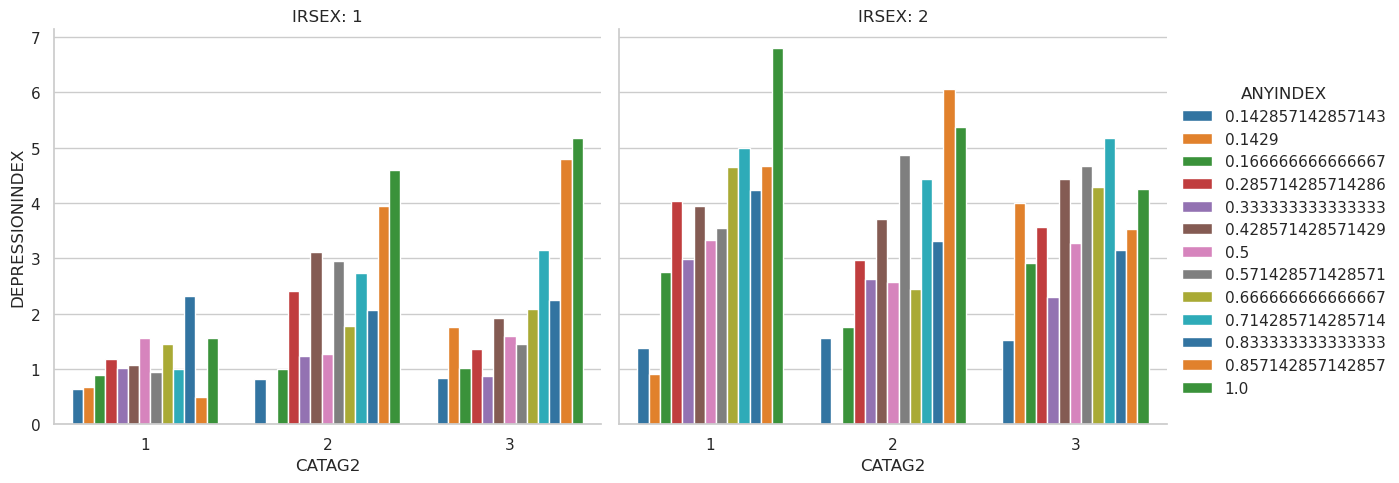

In [48]:
grouped_data = (
    final_data.groupby(['CATAG2', 'ANYINDEX', 'IRSEX'], as_index=False)
    .agg({'DEPRESSIONINDEX': 'mean'})
)

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=grouped_data,
    x='CATAG2',
    y='DEPRESSIONINDEX',
    hue='ANYINDEX',
    col='IRSEX',
    kind='bar',
    palette='tab10',
    height=5,
    aspect=1.2
)

g.set_axis_labels("CATAG2", "DEPRESSIONINDEX")
g.set_titles("IRSEX: {col_name}")
g.legend.set_title("ANYINDEX")

plt.show()

Jak widać na powyższym wykresie przedstawiającym średnią wartość poziomu depresji zależną od wskaźnika uzależnienia od narkotyków z rozdzieleniem na wiek i płeć, można zauważyć ogólnie, że im osoba jest bardziej uzależniona tym ma większą skłonność do popadania w głębszą depresję. Wyróżniającą się wartością jest wartość ANYINDEX = 1 dla płci żeńśkiej w przedziale wiekowym 12-17, gdzie ten poziom depresji jest największy. Ogólnie poziom depresji dla tej grupy wiekowej porównując obie płcie jest bardzo różniący się, co może świadczyć o tym, że młode kobiety są bardziej emocjonalne i łatwiej ulegają używkom

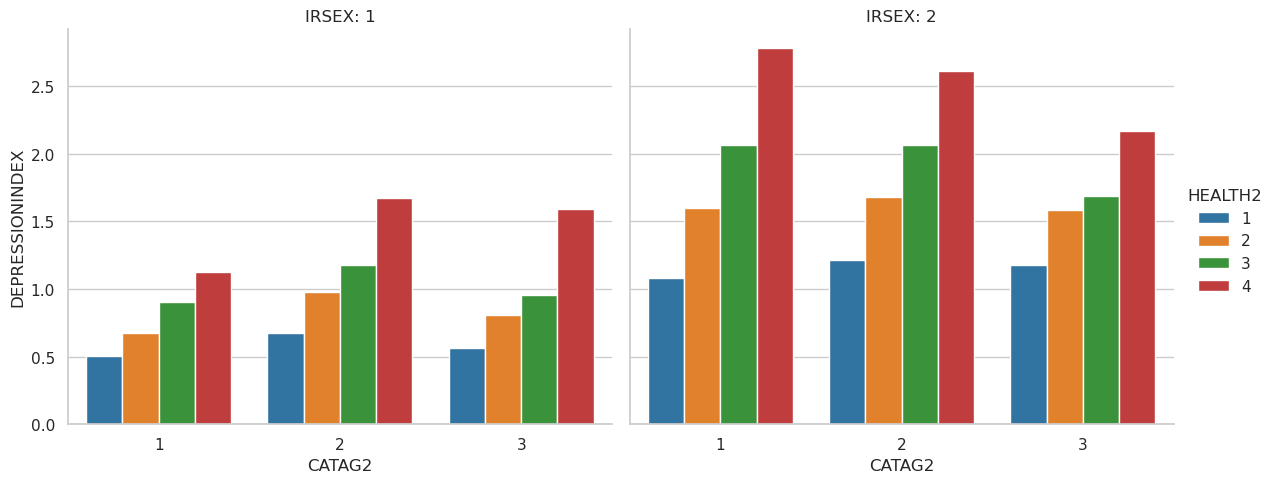

In [49]:
grouped_data = (
    final_data.groupby(['CATAG2', 'HEALTH2', 'IRSEX'], as_index=False)
    .agg({'DEPRESSIONINDEX': 'mean'})
)

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=grouped_data,
    x='CATAG2',
    y='DEPRESSIONINDEX',
    hue='HEALTH2',
    col='IRSEX',
    kind='bar',
    palette='tab10',
    height=5,
    aspect=1.2
)

g.set_axis_labels("CATAG2", "DEPRESSIONINDEX")
g.set_titles("IRSEX: {col_name}")
g.legend.set_title("HEALTH2")

plt.show()

Jak widać na powyższym wykresie przedstawiającym średnią wartość poziomu depresji zależną od poziomu zdrowia z rodzieleniem na wiek i płeć, można zauważyć że im gorsze zdrowie, tym poziom depresji u człowieka (zarowno w przypadku mężczyzn i kobiet) jest wyższy. Warto zauważyć że u kobiet ten współczynnik przyjmuje większe wartości niż u mężczyzn

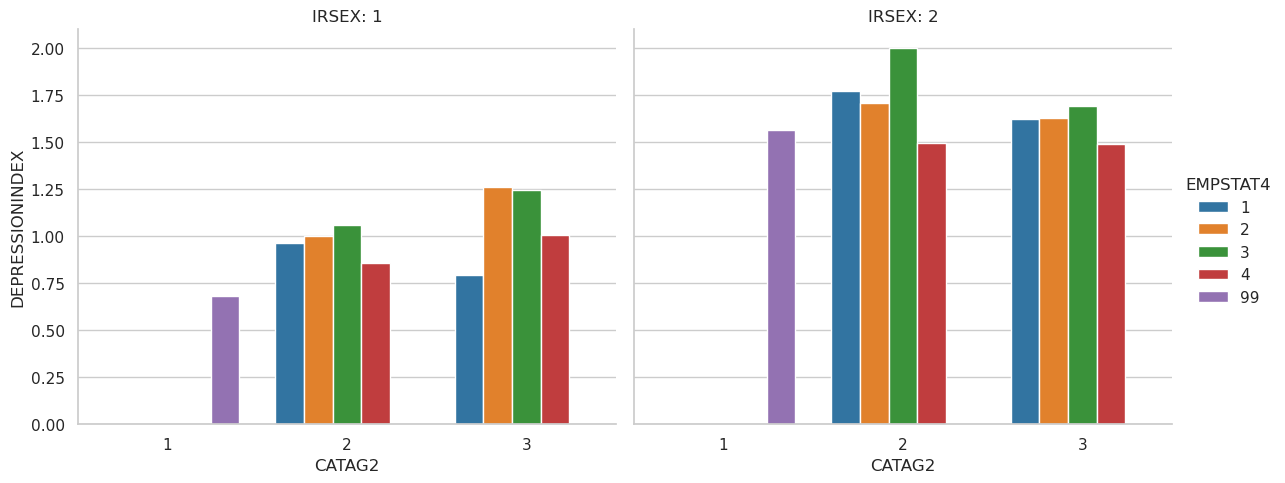

In [50]:
grouped_data = (
    final_data.groupby(['CATAG2', 'EMPSTAT4', 'IRSEX'], as_index=False)
    .agg({'DEPRESSIONINDEX': 'mean'})
)

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=grouped_data,
    x='CATAG2',
    y='DEPRESSIONINDEX',
    hue='EMPSTAT4',
    col='IRSEX',
    kind='bar',
    palette='tab10',
    height=5,
    aspect=1.2
)

g.set_axis_labels("CATAG2", "DEPRESSIONINDEX")
g.set_titles("IRSEX: {col_name}")
g.legend.set_title("EMPSTAT4")

plt.show()

Jak widać na powyższym wykresie przedstawiającym średnią wartość poziomu depresji zależną od rodzaju zatrudnienia z rodzieleniem na wiek i płeć, mozna zauważyć, że ta cecha nie ma aż takiego wpływu na rozwój depresji jak poprzednie omawiane czynniki, jednak mimo wszystko można zauważyć, że osoby które są bezrobotne mają większą tendencję do popadania w depresje. Może wynikać to z rosnącej presji, że dana osoba nie ma pracy lub też ma za dużo wolnego czasu w porównaniu z osobami, które pracują i nie mają czasu na tego typu rozmyślania

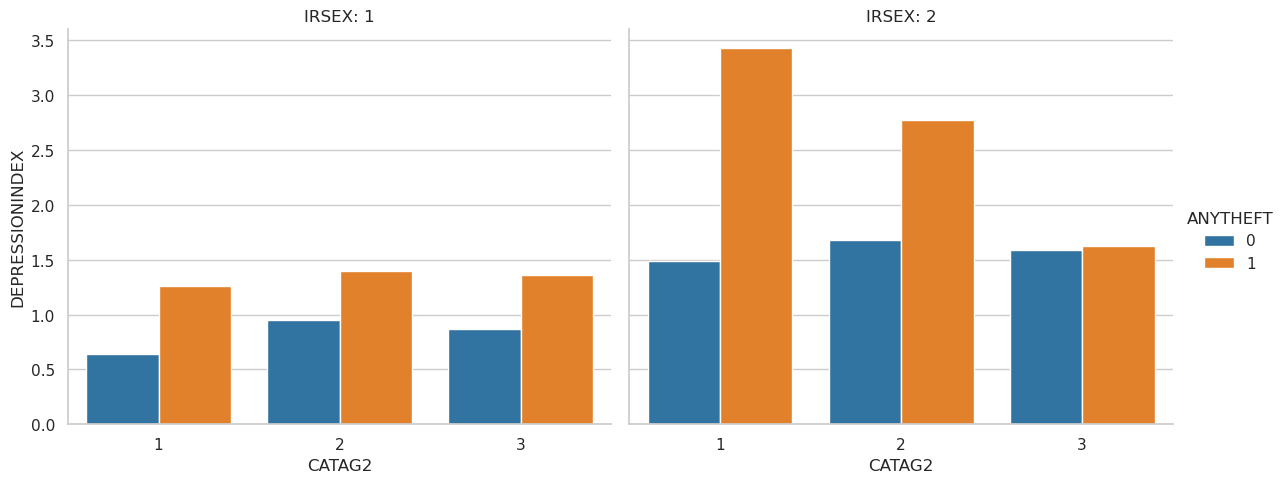

In [51]:
grouped_data = (
    final_data.groupby(['CATAG2', 'ANYTHEFT', 'IRSEX'], as_index=False)
    .agg({'DEPRESSIONINDEX': 'mean'})
)

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=grouped_data,
    x='CATAG2',
    y='DEPRESSIONINDEX',
    hue='ANYTHEFT',
    col='IRSEX',
    kind='bar',
    palette='tab10',
    height=5,
    aspect=1.2
)

g.set_axis_labels("CATAG2", "DEPRESSIONINDEX")
g.set_titles("IRSEX: {col_name}")
g.legend.set_title("ANYTHEFT")

plt.show()

Jak widać na powyższym wykresie przedstawiającym średni poziom depresji w zależności od tego czy dana osoba popełniła jakieś przestępstwo bądź nie, z rodzieleniem na wiek i płeć, można zauważyć jasną tendencję, że osoba, która popełniła jakiekolwiek wykroczenie ma większą skłonność do popadania w głębszą depresję od tych osób, które takiego wykroczenia nie popełniły. Widać również, że w przypadku mężczyzn ten poziom w przypadku popełnienia przestępstwa jest w miarę równy, w przeciwieństwie do kobiet, gdzie to z wiekiem ten współczynnik maleje z ok. 3.5 do ok. 1.5, czyli jest na zbliżonym poziomie co u kobiet, które nie miały problemów z prawem

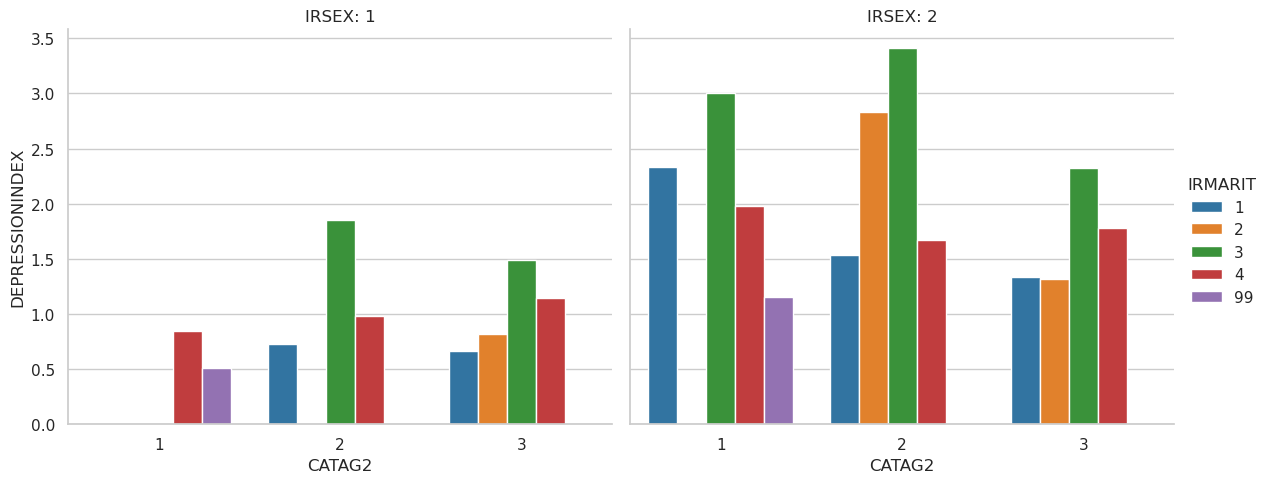

In [52]:
grouped_data = (
    final_data.groupby(['CATAG2', 'IRMARIT', 'IRSEX'], as_index=False)
    .agg({'DEPRESSIONINDEX': 'mean'})
)

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=grouped_data,
    x='CATAG2',
    y='DEPRESSIONINDEX',
    hue='IRMARIT',
    col='IRSEX',
    kind='bar',
    palette='tab10',
    height=5,
    aspect=1.2
)

g.set_axis_labels("CATAG2", "DEPRESSIONINDEX")
g.set_titles("IRSEX: {col_name}")
g.legend.set_title("IRMARIT")

plt.show()

Na powyższym wykresie przedstawiającym średni poziom depresji w zależności od statusu społecznego danej osoby z rodzieleniem na płec i wiek, można zauważyć, że osoby rozwiedzione mają większe skłonności do popadania w głębszą depresję od osób które są pobrały się lub są wdowcami, czy też nigdy nie brały ślubu albo są za młode. Ciekawym spostrzeżeniem jest fakt, że w grupie mężczyzn w pierwszym przedziale wiekowym nie ma ani jednej osoby, która by wzięła ślub, w przeciwieństwie do kobiet z tej samej grupy, gdzie jak widać są przypadku zamążpójścia i rozwiedzenia się

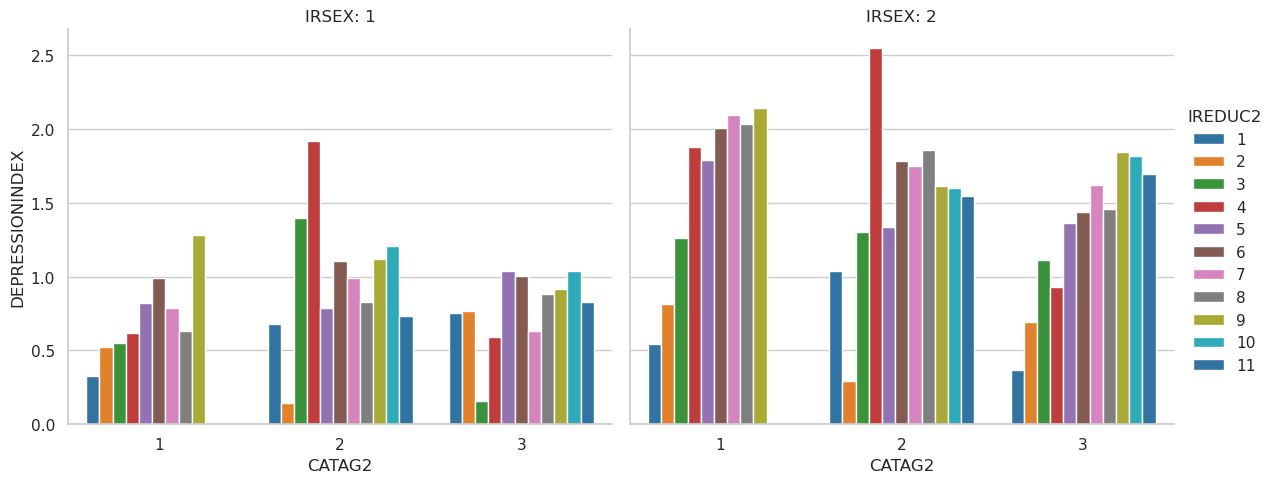

In [53]:
grouped_data = (
    final_data.groupby(['CATAG2', 'IREDUC2', 'IRSEX'], as_index=False)
    .agg({'DEPRESSIONINDEX': 'mean'})
)

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=grouped_data,
    x='CATAG2',
    y='DEPRESSIONINDEX',
    hue='IREDUC2',
    col='IRSEX',
    kind='bar',
    palette='tab10',
    height=5,
    aspect=1.2
)

g.set_axis_labels("CATAG2", "DEPRESSIONINDEX")
g.set_titles("IRSEX: {col_name}")
g.legend.set_title("IREDUC2")

plt.show()

Na powyższym wykresie przedstawiającym średnią wartość depresji w zależności od poziomu edukacji z rodzieleniem na wiek i płeć, mozna zauważyć że osoby z mniejszym wykształceniem mają mniejszą skłonność do popadania w depresję. Jak widać na wykresie, im wyższy stopień tym większa szansa na depresję, co prawda tendecja wzrostowa jest do pewnego momentu, ponieważ potem widać że im osoba jest bardziej wykształcona, tym ten poziom jest mniej więcej stały. Wyjątkiem jest wartość IREDUC = 4 dla CATAG2 = 2 dla obu płci, ponieważ występuje tam swego rodzaju szpila (może złożyło się tak, że z tej klasy brało więcej uczniów, którzy mają depresję od pozostałych stąd taki wynik)

##### Obserwacje

Podsumowując moją analizę wybranych czynników, które mają wpływ na poziom depresji u badanej grupy osób, dochodzę do wniosku, że cecha, która ma największy udział to DSTCHEER. Natomiast cechą, która ma najmniejszy udział jest EMPSTAT4 (chodziło mi o to że jej wartości dużo nie różnią się od bazowego interceptu). Przez wzgląd na brakujące wartości, należy wziąć poprawkę na to, że otrzymane przeze mnie wyniki mogą posiadać błędy. Resztę obserwacji opisałem powyżej, więc nie będę ich tutaj powtarzał

## FAZA II - predykcja

1. Stwórz model regresyjny umożliwiający oszacowanie natężenia depresji u danej osoby lub model, który dokonuje klasyfikacji na osoby z depresją i bez - decyzję które podejście wybrać podejmij w oparciu o własne testy i analizy.


W moim przypadku postawiłem na model, który będzie umożliwiał oszacowanie natężenia depresji u danej osoby

In [54]:
train_data, val_data = train_test_split(final_data, test_size=0.2,stratify=final_data['CATAG2'],random_state=42)

print(f"Zbiór treningowy: {train_data.shape[0]}")
print(f"Zbiór walidacyjny: {val_data.shape[0]}")

formula_reg = """
DEPRESSIONINDEX ~ C(IREDUC2) + C(IRMARIT) + C(HEALTH2) + C(DSTCHEER) + C(ANYINDEX) + C(ANYTHEFT) + C(EMPSTAT4)
"""
model_reg = ols(formula=formula_reg, data=train_data)
res_reg = model_reg.fit()
# res_reg.summary()

Zbiór treningowy: 29577
Zbiór walidacyjny: 7395


2. Dokonaj ocenę modelu, (użyj do tego zbioru walidacyjnego), pamiętaj żeby ten zbiór miał możliwie podobny rozkład populacji

In [55]:
val_X = val_data[['IREDUC2', 'IRMARIT', 'HEALTH2', 'DSTCHEER', 'ANYINDEX', 'ANYTHEFT', 'EMPSTAT4']]
val_X = sm.add_constant(pd.get_dummies(val_X, drop_first=True))
val_y = val_data['DEPRESSIONINDEX']

val_predictions = res_reg.predict(val_X)

mse = mean_squared_error(val_y, val_predictions)
mae = mean_absolute_error(val_y, val_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 6.315716603859546
Mean Absolute Error (MAE): 1.7167450076654205


3. Przeanalizuj wyjście z modelu, którym jest prawdopodobieństwo przynależności do danej klasy, w tym celu jeżeli wykorzystałeś model regresyjny możesz zastosować na wyjściu aktywację w postaci funkcji sigmoidalnej

In [56]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid_predictions = sigmoid(val_predictions)

print(sigmoid_predictions[:10]) 

8971     0.891962
7704     0.982598
34642    0.866108
54341    0.787276
21261    0.708442
21949    0.832508
39954    0.597024
43014    0.787276
31998    0.762567
9927     0.984407
dtype: float64


4. Posortuj otrzymane wyniki po wartości prawdopodobieństwa i podziel je na 5-8 równolicznych grup, dla każdej z tych grup wyznacz ryzyko wystąpienia depresji (bazując na ilorazie liczby osób z depresją i całkowitej liczby osób). Wyświetl wykres zmian ryzyka dla poszczególnych grup

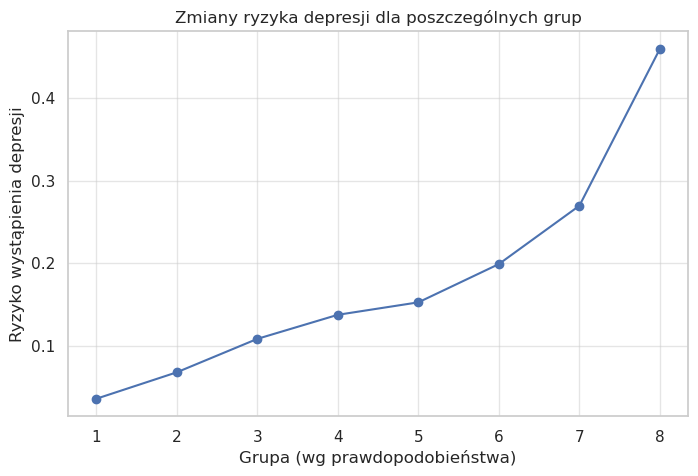

In [57]:
data_prob = pd.DataFrame({
    "Probability": sigmoid_predictions,
    "DepressionIndex": val_y
})

data_prob = data_prob.sort_values(by="Probability").reset_index(drop=True)
data_prob["Group"] = pd.qcut(data_prob["Probability"], q=8, labels=range(1, 9))
data_prob["Depressed"] = data_prob["DepressionIndex"] >= 1

group_risk = data_prob.groupby("Group", observed=False).agg(
    Total=("Depressed", "size"),
    Depressed=("Depressed", "sum")
)
group_risk["Risk"] = group_risk["Depressed"] / group_risk["Total"]
group_risk.reset_index(inplace=True)
group_risk["Group"] = group_risk["Group"].astype(str)

plt.figure(figsize=(8, 5))
plt.plot(group_risk["Group"].to_numpy(), group_risk["Risk"].to_numpy(), marker="o", linestyle="-", color="b")
plt.title("Zmiany ryzyka depresji dla poszczególnych grup")
plt.xlabel("Grupa (wg prawdopodobieństwa)")
plt.ylabel("Ryzyko wystąpienia depresji")
plt.grid(alpha=0.5)
plt.show()



Jak widać na powyższym wykresie przedstawiającym zmiany ryzyka depresji dla poszczególnych grup, wraz ze wzrostem grupy ryzyko wystąpnienia depresji jest większe

5. Stwórz tablicę przeglądania lub model, który, będzie klasyfikowała daną obserwację do jednej z wyznaczonych grup ryzyka

In [58]:
X_train = pd.get_dummies(train_data[['IREDUC2', 'IRMARIT', 'HEALTH2', 'DSTCHEER', 'ANYINDEX', 'ANYTHEFT', 'EMPSTAT4']], drop_first=True)
y_train = (train_data['DEPRESSIONINDEX'] >= 1).astype(int)

X_val = pd.get_dummies(val_data[['IREDUC2', 'IRMARIT', 'HEALTH2', 'DSTCHEER', 'ANYINDEX', 'ANYTHEFT', 'EMPSTAT4']], drop_first=True)
y_val = (val_data['DEPRESSIONINDEX'] >= 1).astype(int)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, y_train)

val_probs = log_model.predict_proba(X_val_scaled)[:, 1]

val_data["Probability"] = val_probs
val_data["Group"] = pd.qcut(val_probs, q=8, labels=range(1, 9))

group_thresholds = pd.qcut(val_probs, q=8, retbins=True)[1]
print("Granice grup ryzyka:", group_thresholds)

def classify_risk(observation, model, scaler, group_thresholds):

    observation = pd.DataFrame([observation])
    observation = pd.get_dummies(observation, drop_first=True)

    for col in X_train.columns:
        if col not in observation.columns:
            observation[col] = 0
    observation = observation[X_train.columns]

    observation_scaled = scaler.transform(observation)

    prob = model.predict_proba(observation_scaled)[:, 1][0]

    for i in range(len(group_thresholds) - 1):
        if group_thresholds[i] <= prob < group_thresholds[i + 1]:
            return i + 1
    return len(group_thresholds) - 1

example_observation = {
    "IREDUC2": 5,
    "IRMARIT": 4,
    "HEALTH2": 1,
    "DSTCHEER": 4,
    "ANYINDEX": 0.5,
    "ANYTHEFT": 0,
    "EMPSTAT4": 1
}
group = classify_risk(example_observation, log_model, scaler, group_thresholds)
print(f"Obserwacja została przypisana do grupy ryzyka: {group}")


Granice grup ryzyka: [0.03217165 0.09981449 0.12132375 0.13818418 0.15309443 0.17679022
 0.20769715 0.2550978  0.76349811]
Obserwacja została przypisana do grupy ryzyka: 2


6. Dla zbioru walidacyjnego oceń jak wygląda liczebność poszczególnych grup ryzyka

Liczebność poszczególnych grup ryzyka:
Group
1    930
2    941
3    920
4    926
5    991
6    840
7    923
8    924
Name: count, dtype: int64


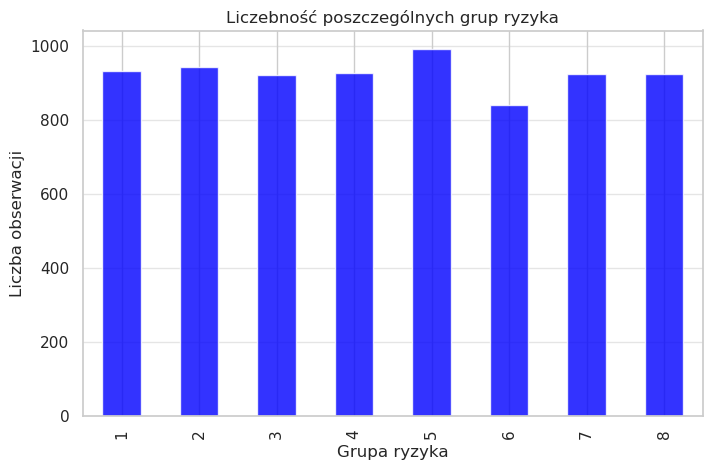

In [59]:
group_counts = val_data["Group"].value_counts().sort_index()

print("Liczebność poszczególnych grup ryzyka:")
print(group_counts)

plt.figure(figsize=(8, 5))
group_counts.plot(kind="bar", color="blue", alpha=0.8)
plt.title("Liczebność poszczególnych grup ryzyka")
plt.xlabel("Grupa ryzyka")
plt.ylabel("Liczba obserwacji")
plt.grid(axis="y", alpha=0.5)
plt.show()

Jak widać na powyższym wykresie przedstawiającym liczebność poszczególnych grup ryzyka, rozkład osób między grupami jest równomierny z małymi oscylacjami

7. Na podstawie parametrów modelu regresyjnego przeanalizuj grupę o najniższym i najwyższym poziomie ryzyka depresji, spróbuj ją scharakteryzować.

In [60]:
print(res_reg.params)

Intercept                           3.336771
C(IREDUC2)[T.2]                     0.151984
C(IREDUC2)[T.3]                     0.383752
C(IREDUC2)[T.4]                     0.619145
C(IREDUC2)[T.5]                     0.559013
C(IREDUC2)[T.6]                     0.748590
C(IREDUC2)[T.7]                     0.718172
C(IREDUC2)[T.8]                     0.883930
C(IREDUC2)[T.9]                     1.050752
C(IREDUC2)[T.10]                    1.136347
C(IREDUC2)[T.11]                    1.229072
C(IRMARIT)[T.2]                    -0.021746
C(IRMARIT)[T.3]                     0.625402
C(IRMARIT)[T.4]                    -0.172079
C(IRMARIT)[T.99]                   -0.348295
C(HEALTH2)[T.2]                     0.231661
C(HEALTH2)[T.3]                     0.417019
C(HEALTH2)[T.4]                     0.697320
C(DSTCHEER)[T.2]                   -0.492485
C(DSTCHEER)[T.3]                   -2.526784
C(DSTCHEER)[T.4]                   -3.572479
C(DSTCHEER)[T.5]                   -4.192329
C(DSTCHEER

In [61]:
lowest_risk_group = val_data[val_data["Group"] == 1]
lowest_group = lowest_risk_group.describe(include="all")

print(lowest_group)

        DEPRESSIONINDEX      CATAG2       IRSEX        SOMA    ANYINDEX  \
count        930.000000  930.000000  930.000000  930.000000  930.000000   
unique              NaN         NaN         NaN         NaN         NaN   
top                 NaN         NaN         NaN         NaN         NaN   
freq                NaN         NaN         NaN         NaN         NaN   
mean           0.334409    1.961290    1.408602   93.708602    0.143344   
std            1.452143    0.853415    0.491840   22.210899    0.005446   
min            0.000000    1.000000    1.000000    0.000000    0.142857   
25%            0.000000    1.000000    1.000000   99.000000    0.142857   
50%            0.000000    2.000000    1.000000   99.000000    0.142857   
75%            0.000000    3.000000    2.000000   99.000000    0.142857   
max            9.000000    3.000000    2.000000   99.000000    0.285714   

           IREDUC2    EMPSTAT4  ANYTHEFT    DSTCHEER     HEALTH2     IRMARIT  \
count   930.000000 

Grupa o najniższym poziomie ryzyka depresji, charakteryzuje się średnim poziomie depresji (DEPRESSIONINDEX) na poziomie 0.33, co może świadczyć o tym, że większość tej grupy to osoby bez depresji. Są to najczęściej osoby z drugiej grupy wiekowej (CATAG2) przedział 18-25, ponieważ średnia tej kategorii wynosi 1.96, co wskazuje też na to, że jest w niej sporo młodzieży a najmniej grupy 26+. W grupie tej jest przewaga płci męskiej (IRSEX na poziomie 1.40), co świadczy o tym, że mężczyźni rzadziej wpadają w depresję od kobiet. Analizując rodzaj depresji (somatyczna lub niesomatyczna - SOMA), ciężko dojść do dobrych wniosków, ponieważ większość danych przyjmuje wartość 99 (missing value dla tego czynnika). Jeżeli chodzi o uzaleznienie od używek (ANYINDEX) to analizowana grupa nie jest podatna na silne uzależenienie od narkotyków ponieważ średnia tej cechy wynosi 0.143344, a maksymalna wartość 0.285714, gdzie dla całej tej kolumny maksymalna wartość to 1. Osoby będące najmniej narażone na depresję średnio są na poziomie "9th grade" edukacji (IREDUCE2) co plasuje ich mniej więcej w połowie całego poziomu wykształcenia. Czynnik EMPSTAT4 ciężko określić ze względu na brakujące wartości równe 99, jednak można zauważyć że w połowie badanej grupy to osoby, które mają stałą pracę, natomiast wartość 99 osoby w przedziale wiekowym 12-17. Jeżeli chodzi o popełnienie kiedykolwiek jakiegoś przestępstwa (ANYTHEFT) to nikt z tej grupy takiego nie popełnił (wartość średnia 0.0). Osoby, które znalazły się w tej grupie charakteryzują się tym, że łatwiej jest je pocieszyć (DSCHEER), ponieważ minimalna wartość w tym czynniku to 3 - Some of the time, spora część to wartość 5 - None of the time. Nie można nic powiedzieć o średniej w tym czynniku ponieważ znajdują się w niej wartości brakujące, które zaburzają średni wynik. Osoby te charakteryzują się również bardzo dobrym/dobrym poziomem zdrowia (HEALTH2), średnia wartość - 1.41. Analizując ostatni czynnik, czyli poziom społeczny (IRMARIT), to przez missing value, cięzko interpretować średnią, jednak widać że są to głównie osoby, które: wzięły ślub lub nigdy się nie pobrały albo nie były brane pod uwagę ponieważ były zbyt młode

In [62]:
highest_risk_group = val_data[val_data["Group"] == 8]
highest_group = highest_risk_group.describe(include="all")

print(highest_group)

        DEPRESSIONINDEX      CATAG2       IRSEX        SOMA    ANYINDEX  \
count        924.000000  924.000000  924.000000  924.000000  924.000000   
unique              NaN         NaN         NaN         NaN         NaN   
top                 NaN         NaN         NaN         NaN         NaN   
freq                NaN         NaN         NaN         NaN         NaN   
mean           2.686147    2.030303    1.600649   63.822511    0.277907   
std            3.661901    0.794859    0.490030   47.110631    0.222485   
min            0.000000    1.000000    1.000000    0.000000    0.142857   
25%            0.000000    1.000000    1.000000    1.000000    0.142857   
50%            0.000000    2.000000    2.000000   99.000000    0.142857   
75%            7.000000    3.000000    2.000000   99.000000    0.333333   
max            9.000000    3.000000    2.000000   99.000000    1.000000   

           IREDUC2    EMPSTAT4    ANYTHEFT    DSTCHEER     HEALTH2  \
count   924.000000  924.00000

Analizując poziom depresji oraz wybrane przeze mnie czynniki w grupie o największym ryzyku wpadnięcia w depresje, można zauważyć, że średnia wartość DEPRESSIONINDEX jest na poziomie 2.68, co świadczy o tym, że średnio każda osoba w tej grupie ma niski poziom depresji. Podobnie jak w przypadku grupy o najniższym ryzyku, są to głownie osoby z drugiej kategorii wiekowej CATAG2. Patrząc na czynnik IRSEX, można dojść do wniosku, że większością tej grupy są kobiety (średnia wartość = 1.6). Odnośnie rodzaju depresji (SOMA), to ciężko cokolwiek stwierdzić, ponieważ podobnie jak w poprzednim przypadku, większość tej kolumny zajmują wartości 99. Jeżeli chodzi o poziom uzależnienia od używek (ANYINDEX) to widać tutaj już większą średnią - 0.27, oraz fakt, że są w tej grupie osoby, które są wpełni uzależnione (maksymalna wartość = 1). Poziom edukacji tych osób również jest większy (IREDUC), ponieważ średnia wartość to 8.05, czyli "12th grade", czyli osoby o większym wykształceniu są bardziej narażone na depresję. Jeżeli chodzi o poziom zatrudnienia (EMPSTAT4), to przez missing value, średnia nie powie nam za wiele, ale patrząc na to jakie wartości występują w tej kolumnie to można zauważyć, że znajdują się w niej osoby, które są bezrobotne, bądź są to osoby, których pracę ciężko określić. Na pewno jest mniejszy udział osób pracujących na pełen etat. W tej grupie widać, że są osoby które popelniły jakieś przestępstwo (ANYTHEFT), co prawda są oni mniejszością ale widać, że osoby z tej grupy są bardziej skłonne do wykroczeń. Analizujac czynnik DSTCHEER, to można zauważyć, że grupa ta posiada osoby, których nie da się pocieszyć albo bardzo trudno to zrobić. Wartość średnia jest zaburzona przez brakujące wartości, ale widać, że im trudniej taką osobę wesprzeć tym ma ona większe skłonności do depresji. Średnia zdrowia (HEALTH2) jest również w tej grupie wyższa - 2.83, co świadczy o tym, że osoby te charakteryzują się gorszym zdrowiem. Patrząc na ostatni czynnik (IRMARIT), można dojść do wniosku, że osoby z tej grupy rzadziej są w związku małżeńskim, częściej są one rozwiedzione lub nigdy nie brały ślubu

#### Porównanie MSE i MAE dla modelu OLS i DecisionTreeRegressor

In [63]:
tree_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_reg.fit(X_train, train_data['DEPRESSIONINDEX'])

val_preds_reg = tree_reg.predict(X_val)

mse_tree = mean_squared_error(val_data['DEPRESSIONINDEX'], val_preds_reg)
mae_tree = mean_absolute_error(val_data['DEPRESSIONINDEX'], val_preds_reg)

print("Regresja drzewa decyzyjnego:")
print(f"MSE: {mse_tree:.4f}")
print(f"MAE: {mae_tree:.4f}")


print("Regresja modelu OLS:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Regresja drzewa decyzyjnego:
MSE: 6.3782
MAE: 1.7149
Regresja modelu OLS:
MSE: 6.315716603859546
MAE: 1.7167450076654205


Analizując MSE i MAE dla obydwóch modeli można dojść do wniosku, że oba modele radzą sobie podobnie